In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchsummary import summary

In [82]:
mnist_train = torchvision.datasets.MNIST('.',train=True, download=False, transform=torchvision.transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST('.',train=False, download=False, transform=torchvision.transforms.ToTensor())

In [83]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=True)

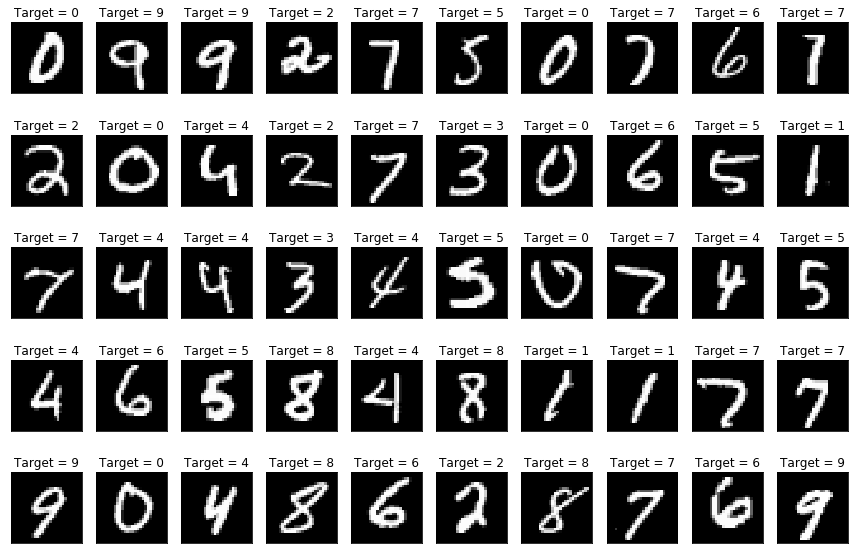

In [84]:
train_data = next(enumerate(train_loader))
batch_idx, (example_data, example_targets) = train_data
plt.figure(figsize=(15,10))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.imshow(example_data[i,0,:,:], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('Target = {}'.format(example_targets[i]))

In [85]:
print(torch.__version__)
print(torch.version.cuda) 
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

1.8.1+cpu
None
False
cpu


In [86]:
class Generator(torch.nn.Module):
    def __init__(self, layers):
        super(Generator, self).__init__()
        self.gen = torch.nn.Sequential()
        for i in range(len(layers)-1):
            if i!=len(layers)-2:
                self.gen.add_module('hid_'+str(i), torch.nn.Linear(layers[i], layers[i+1]))
                self.gen.add_module('batch_'+str(i), torch.nn.BatchNorm1d(layers[i+1]))
                self.gen.add_module('act_'+str(i), torch.nn.LeakyReLU(negative_slope=0.2))
            else:
                self.gen.add_module('hid_'+str(i), torch.nn.Linear(layers[i], layers[i+1]))   
                self.gen.add_module('act_'+str(i), torch.nn.Sigmoid())
    def get_gen(self):
        return self.gen
    def forward(self, inputs):
        return self.gen(inputs.float())

In [87]:
class Discriminator(torch.nn.Module):
    def __init__(self, layers):
        super(Discriminator, self).__init__()
        self.disc = torch.nn.Sequential()
        for i in range(len(layers)-1):
            if i!=len(layers)-2:
                self.disc.add_module('hid_'+str(i), torch.nn.Linear(layers[i], layers[i+1]))
#                 self.disc.add_module('batch_'+str(i), torch.nn.BatchNorm1d(layers[i+1]))
                self.disc.add_module('act_'+str(i), torch.nn.LeakyReLU(negative_slope=0.2))
            else:
                self.disc.add_module('hid_'+str(i), torch.nn.Linear(layers[i], layers[i+1]))            
    def get_gen(self):
        return self.disc
    def forward(self, inputs):
        return self.disc(inputs.float())

In [88]:
gen = Generator(layers=[10, 128, 256, 512, 28*28])
disc = Discriminator(layers=[28*28, 512, 256, 128, 1])
learning_rate = 0.001

In [89]:
gen, disc

(Generator(
   (gen): Sequential(
     (hid_0): Linear(in_features=10, out_features=128, bias=True)
     (batch_0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (act_0): LeakyReLU(negative_slope=0.2)
     (hid_1): Linear(in_features=128, out_features=256, bias=True)
     (batch_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (act_1): LeakyReLU(negative_slope=0.2)
     (hid_2): Linear(in_features=256, out_features=512, bias=True)
     (batch_2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (act_2): LeakyReLU(negative_slope=0.2)
     (hid_3): Linear(in_features=512, out_features=784, bias=True)
     (act_3): Sigmoid()
   )
 ), Discriminator(
   (disc): Sequential(
     (hid_0): Linear(in_features=784, out_features=512, bias=True)
     (act_0): LeakyReLU(negative_slope=0.2)
     (hid_1): Linear(in_features=512, out_features=256, bias=True)
     (act_1): LeakyReLU(neg

In [103]:
summary(gen, (10,))
summary(disc, (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           1,408
       BatchNorm1d-2                  [-1, 128]             256
         LeakyReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 256]          33,024
       BatchNorm1d-5                  [-1, 256]             512
         LeakyReLU-6                  [-1, 256]               0
            Linear-7                  [-1, 512]         131,584
       BatchNorm1d-8                  [-1, 512]           1,024
         LeakyReLU-9                  [-1, 512]               0
           Linear-10                  [-1, 784]         402,192
          Sigmoid-11                  [-1, 784]               0
Total params: 570,000
Trainable params: 570,000
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [74]:
gen.to(device)
disc.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
opt_gen = torch.optim.Adam(gen.parameters(), lr=learning_rate)
opt_disc = torch.optim.Adam(disc.parameters(), lr=learning_rate)

In [75]:
def fun_gen_loss(disc, real, gen, z, criterion, batch_size):
    fake = gen(z)
    disc_fake = disc(fake)
    gen_loss = criterion(disc_fake, torch.ones(batch_size,1))
    return gen_loss
def fun_disc_loss(disc, real, gen, z, criterion, batch_size):
    fake = gen(z).detach()
    disc_real = disc(real)
    disc_fake = disc(fake)
    real_criterion = criterion(disc_real, torch.ones(batch_size,1))
    fake_criterion = criterion(disc_fake, torch.zeros(batch_size,1))
    disc_loss = 0.5*(real_criterion+fake_criterion)
    return disc_loss

In [76]:
def fun_plot(tensor, shape):
    plt.figure(figsize=(20,5))
    image = tensor.view(-1,*shape)
    grid = torchvision.utils.make_grid(image[0:20], nrow=10)
    plt.imshow(grid.permute(1, 2, 0).squeeze())
    plt.xticks([])
    plt.yticks([])
    plt.show()

epoch = 0


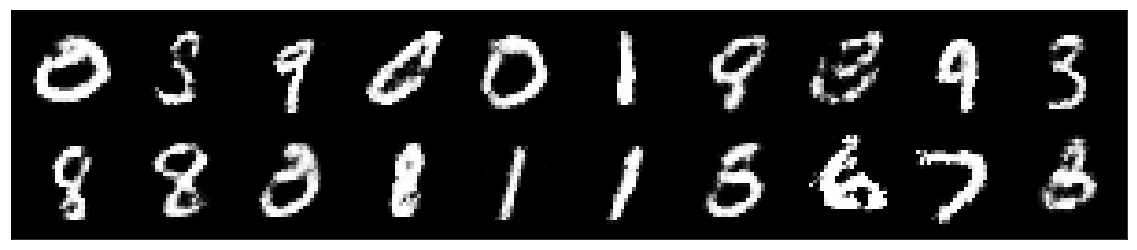

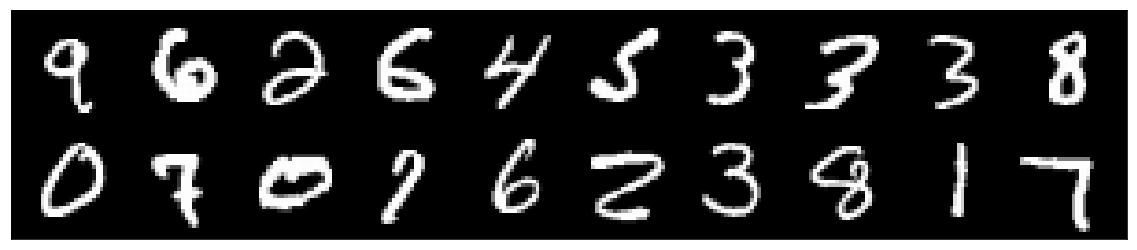

epoch = 1


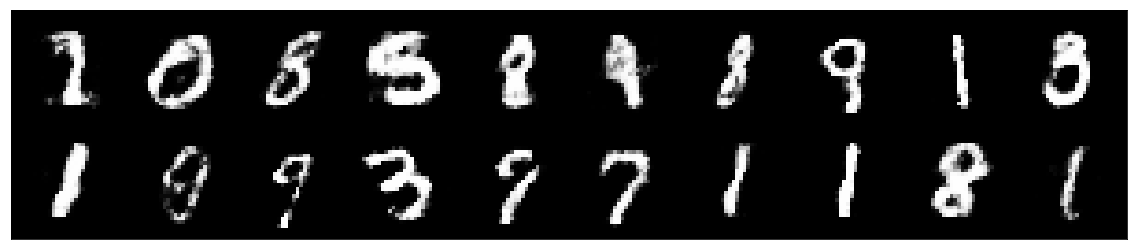

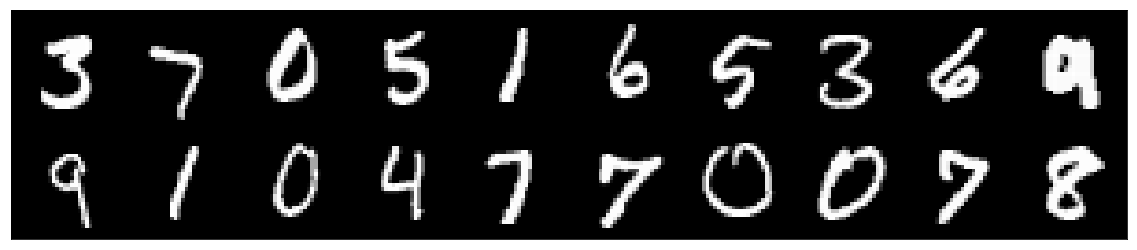

epoch = 2


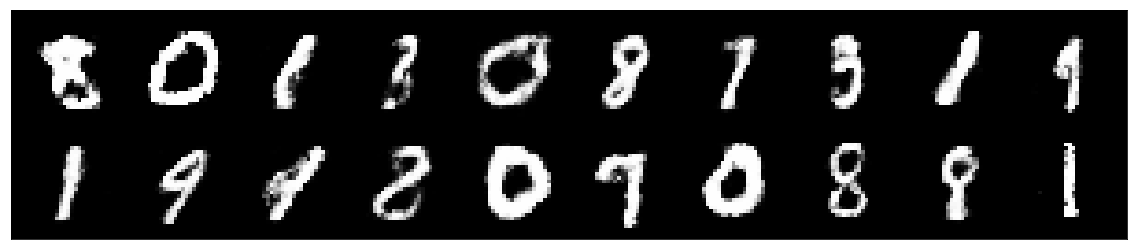

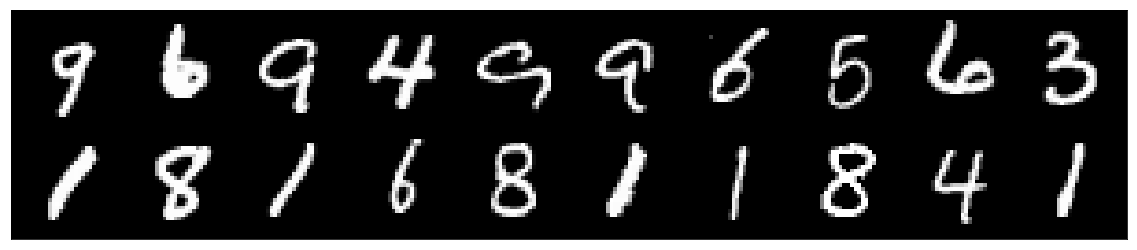

epoch = 3


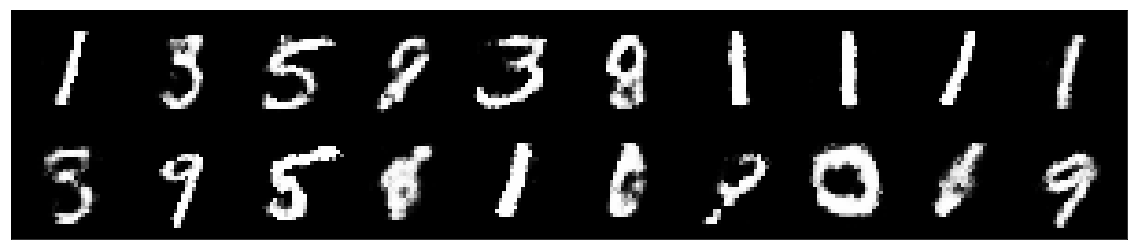

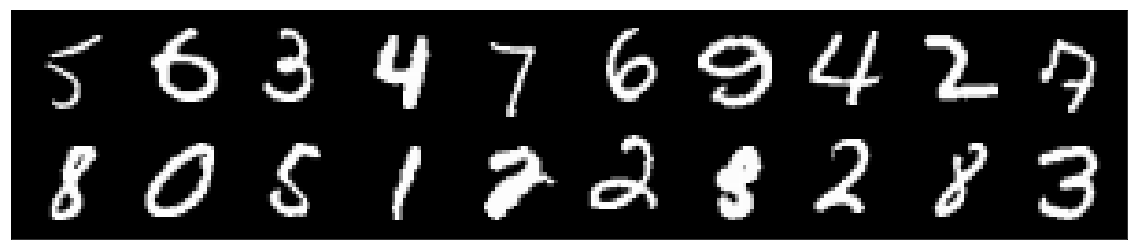

epoch = 4


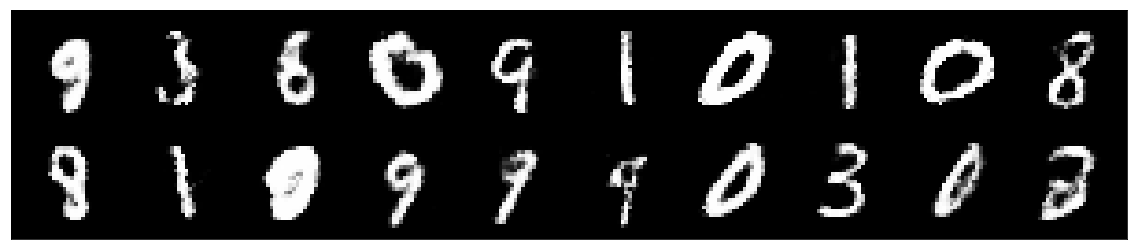

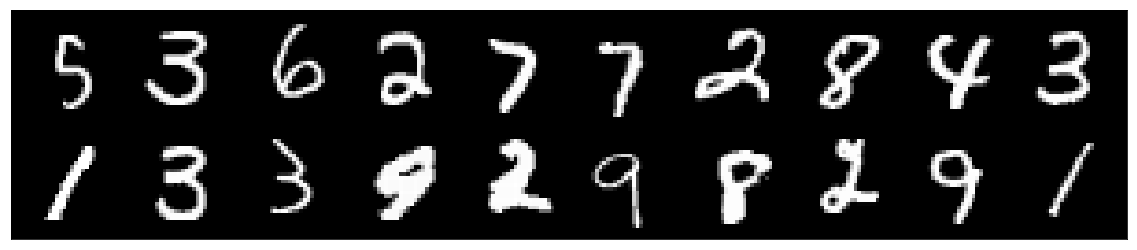

epoch = 5


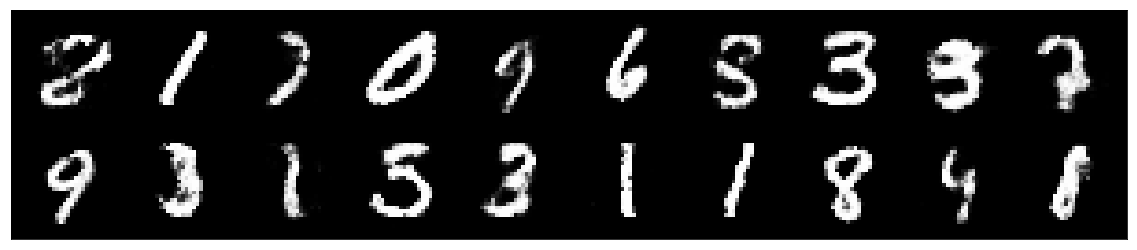

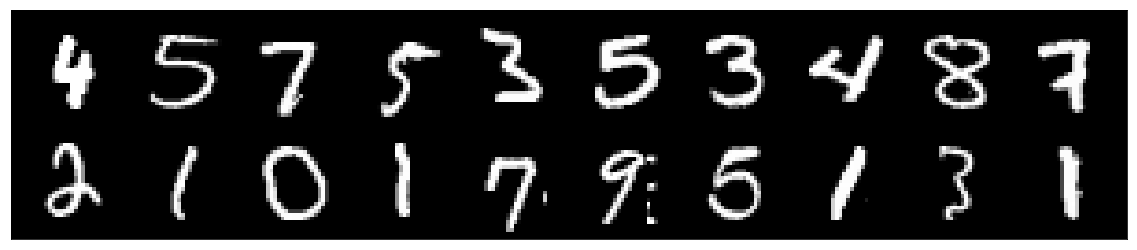

epoch = 6


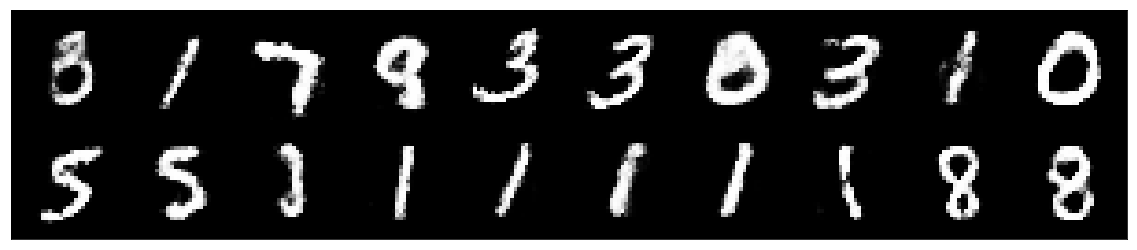

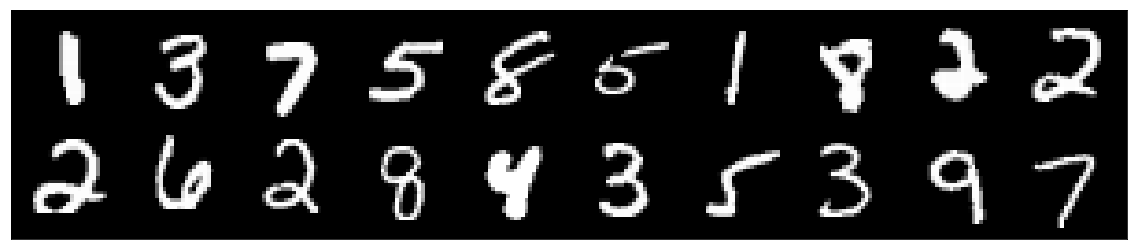

epoch = 7


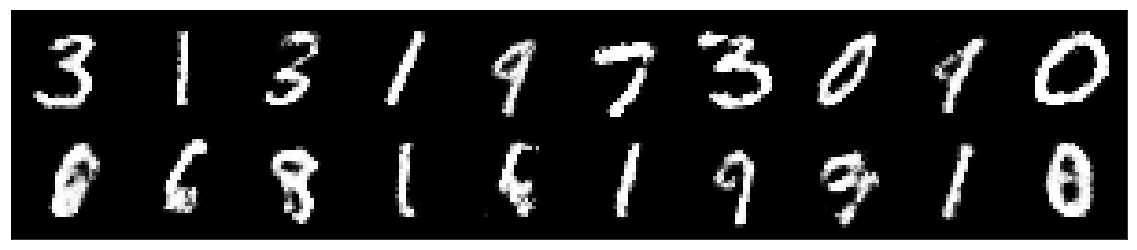

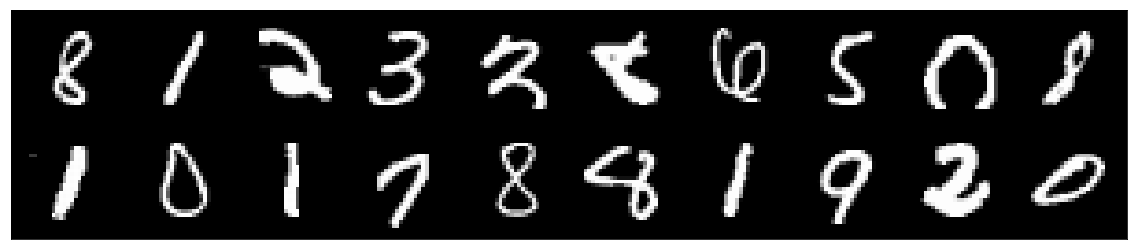

epoch = 8


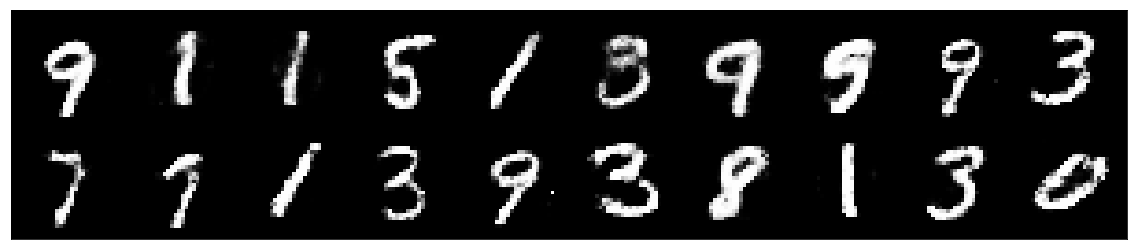

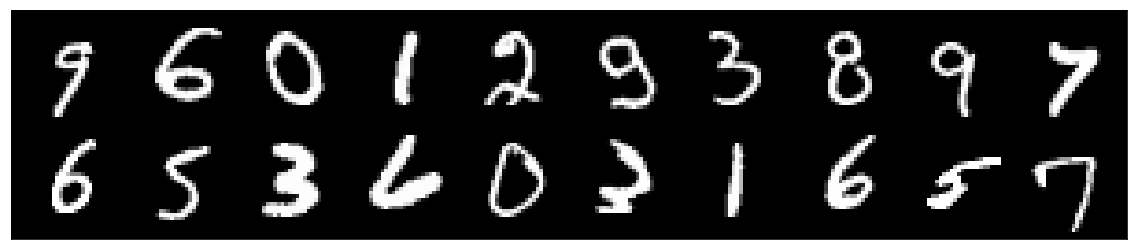

epoch = 9


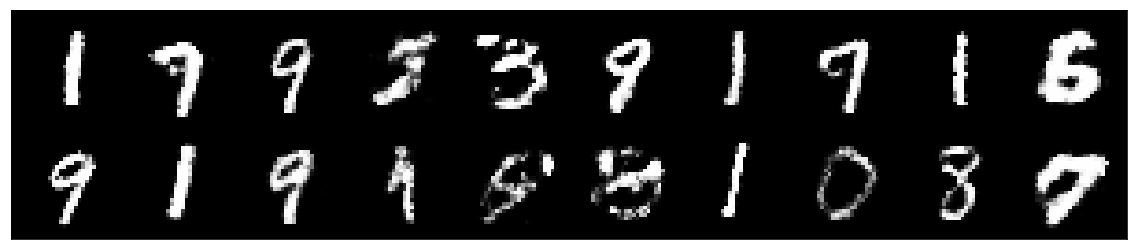

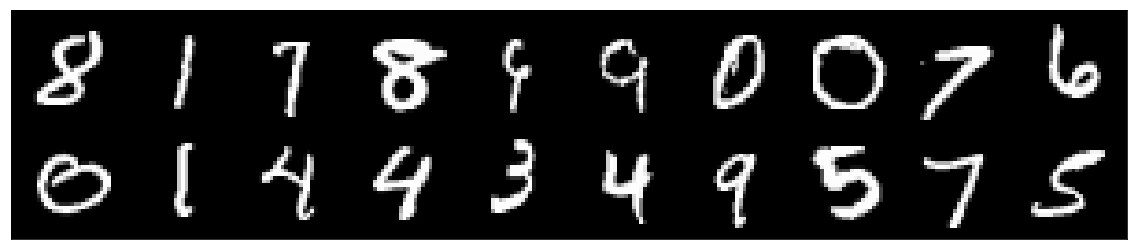

epoch = 10


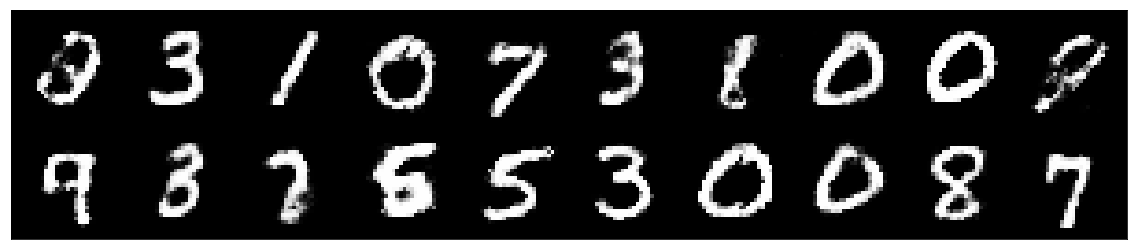

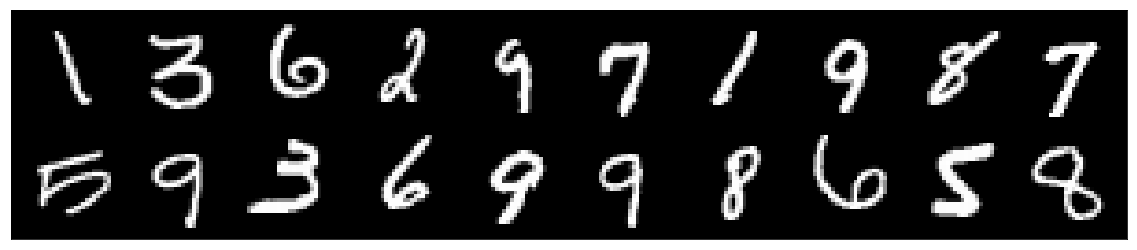

epoch = 11


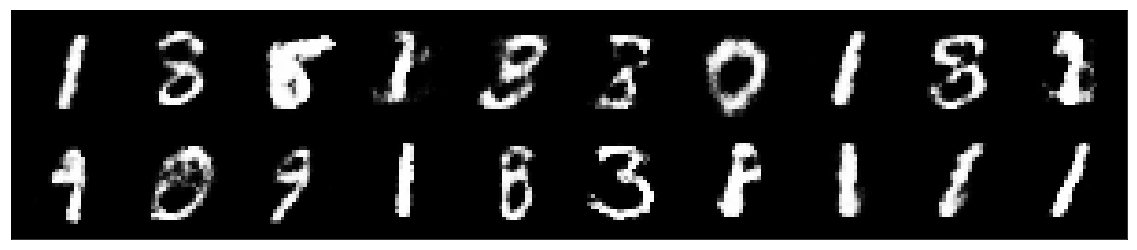

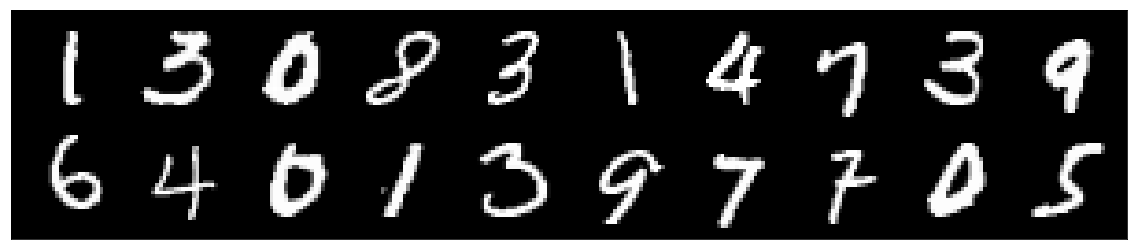

epoch = 12


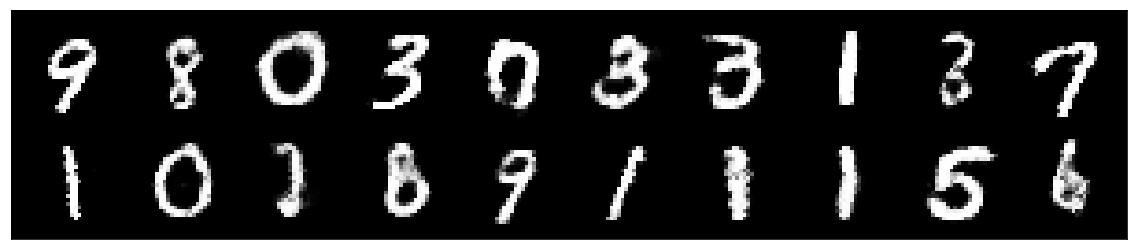

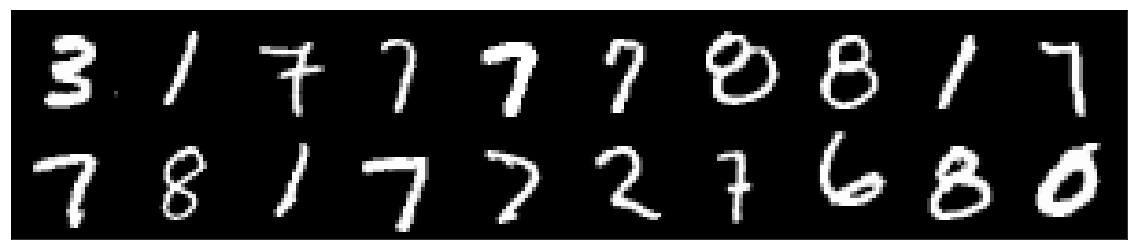

epoch = 13


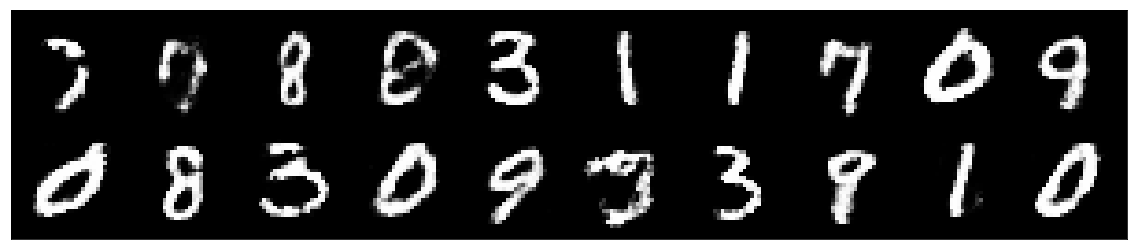

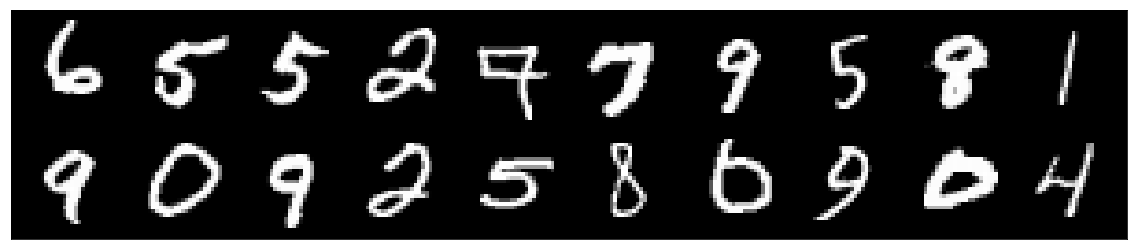

epoch = 14


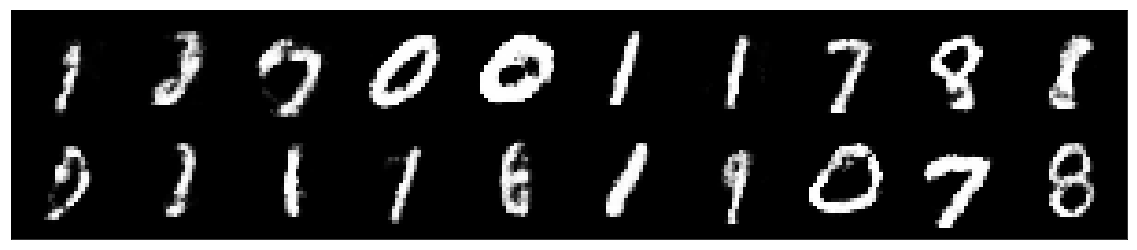

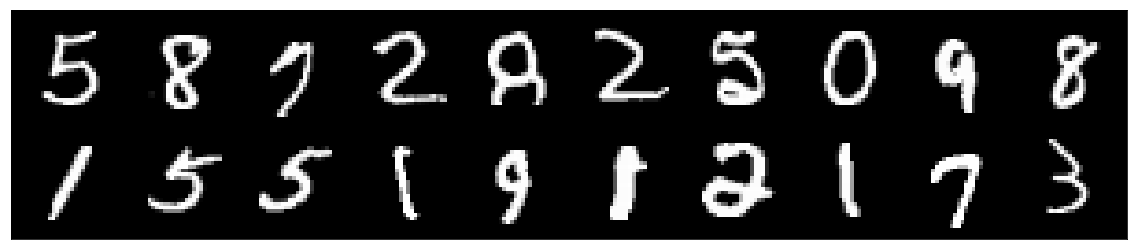

epoch = 15


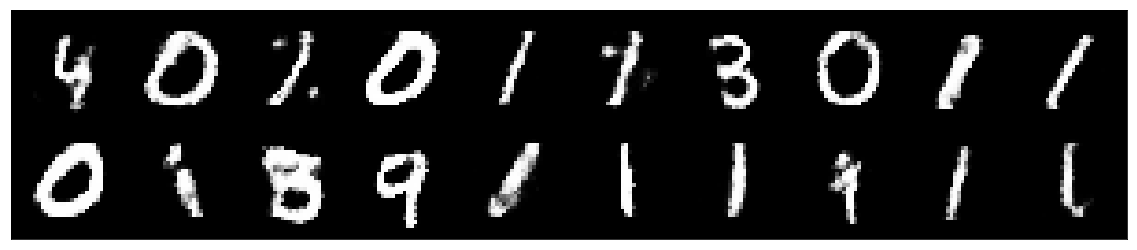

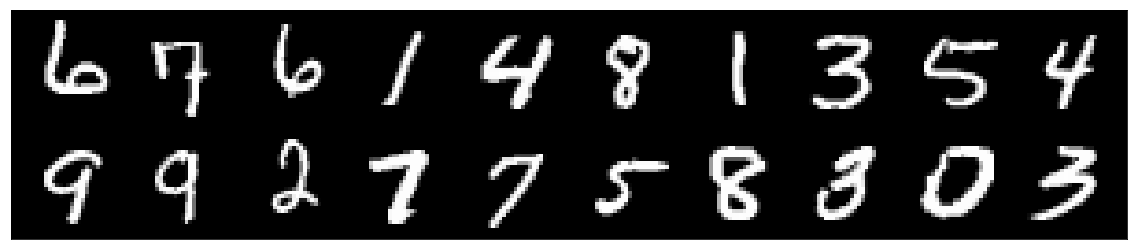

epoch = 16


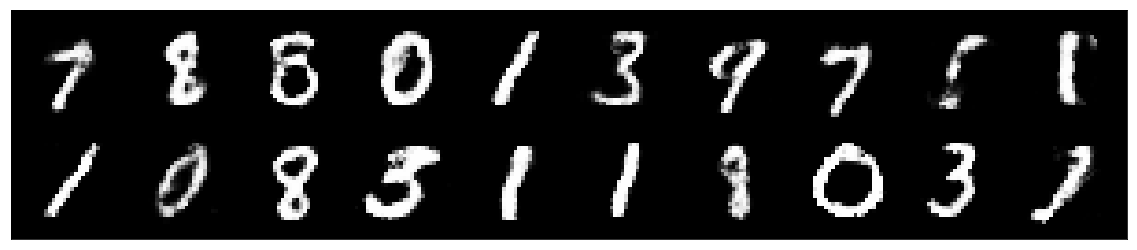

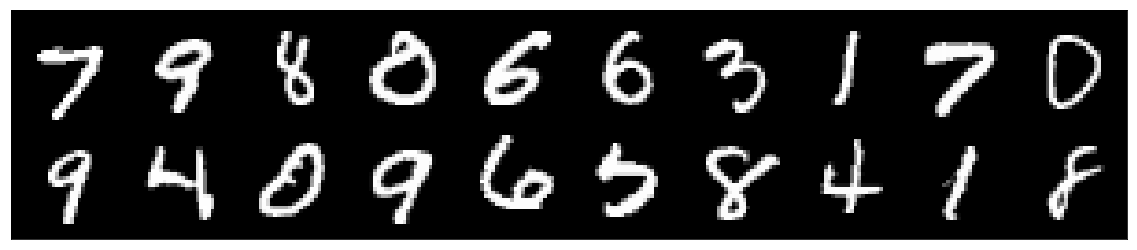

epoch = 17


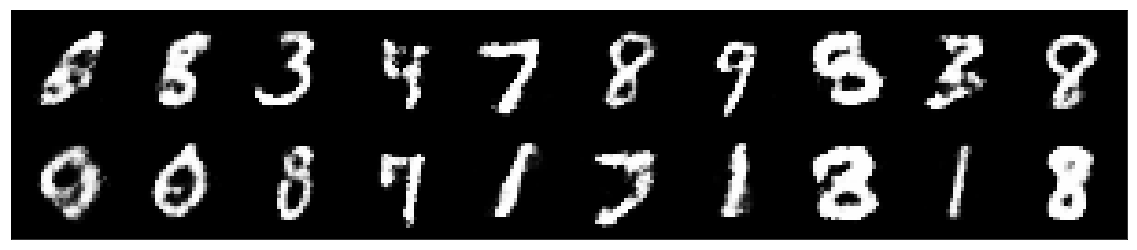

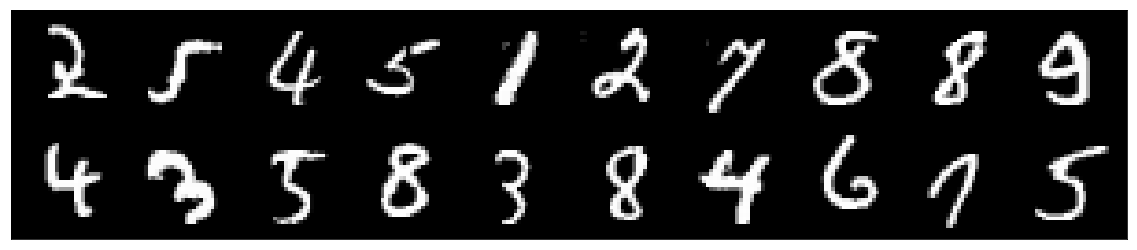

epoch = 18


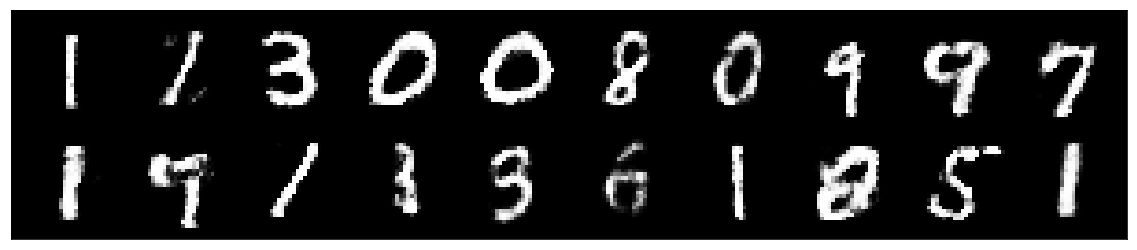

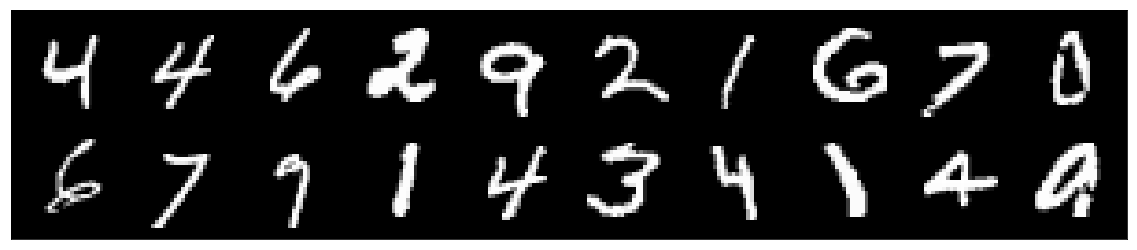

epoch = 19


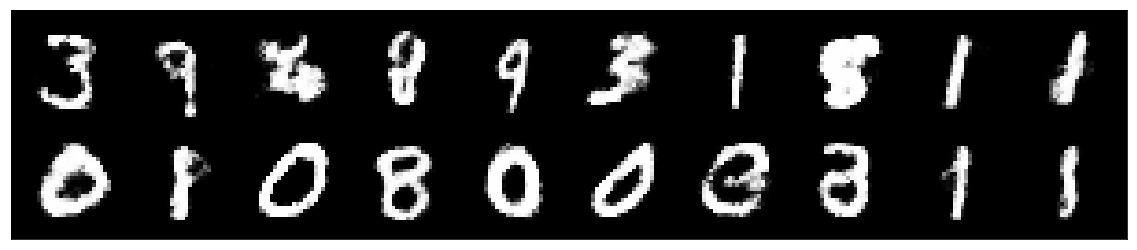

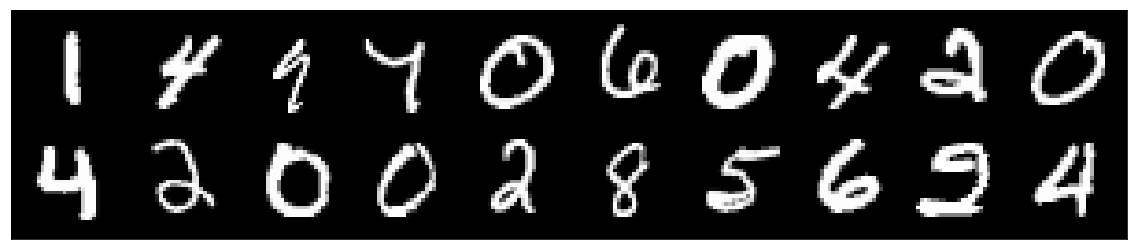

epoch = 20


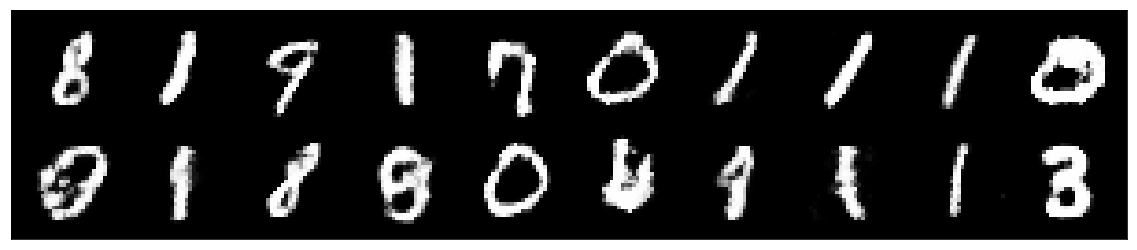

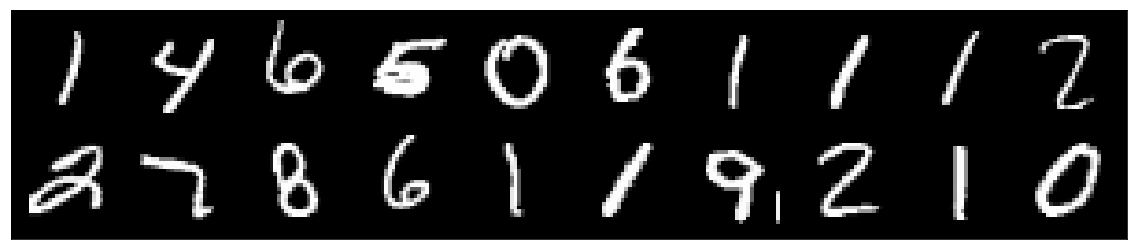

epoch = 21


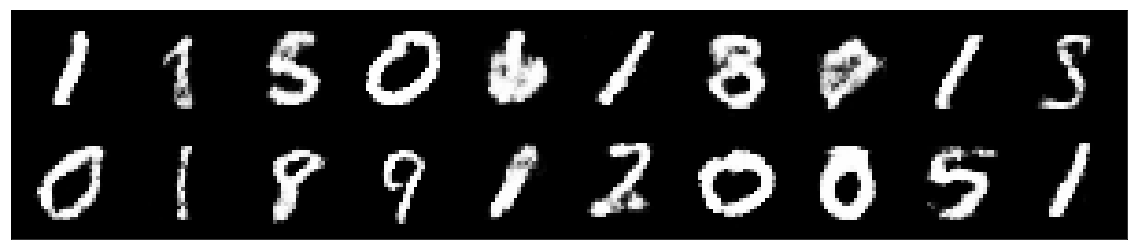

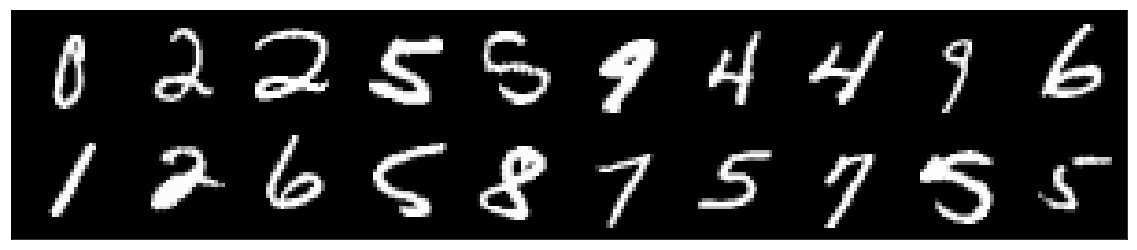

epoch = 22


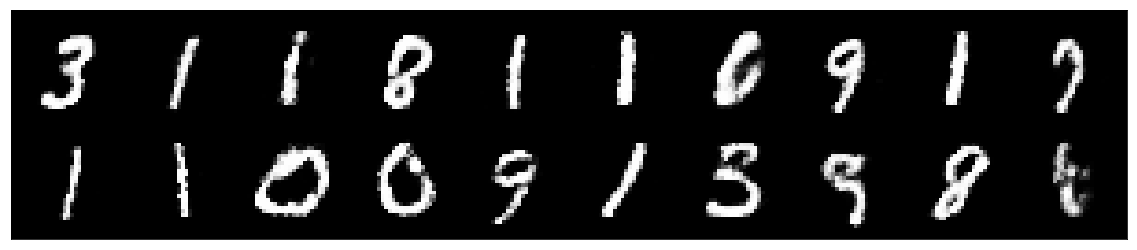

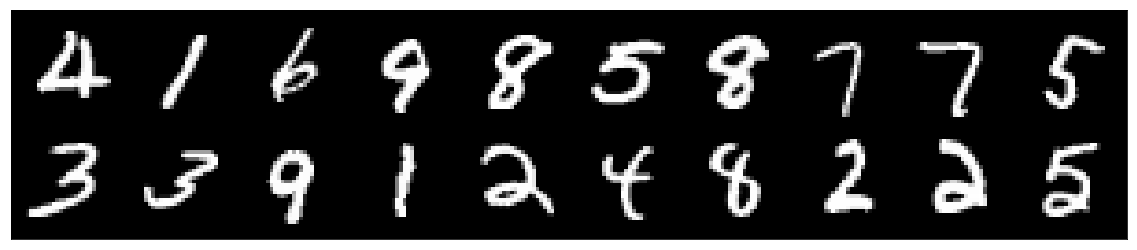

epoch = 23


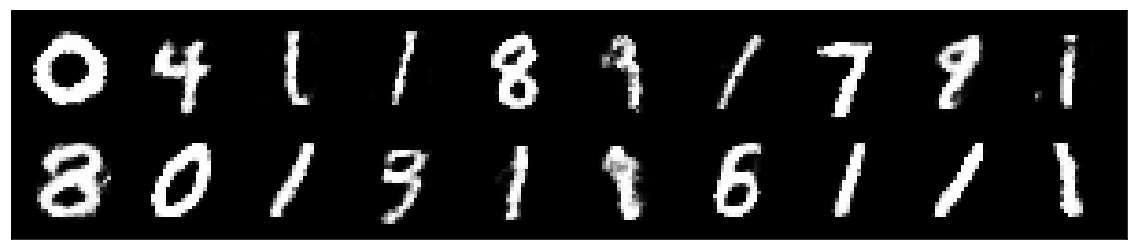

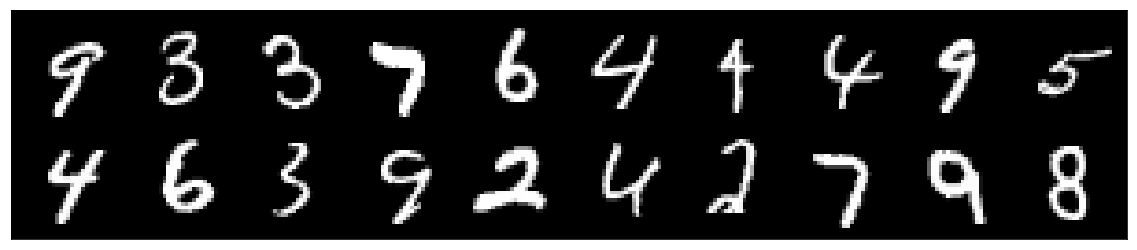

epoch = 24


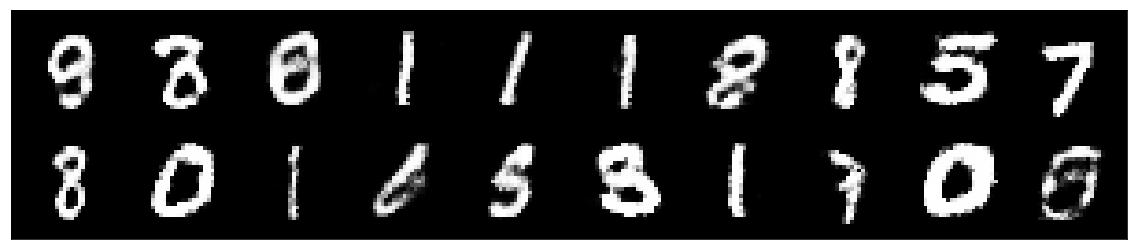

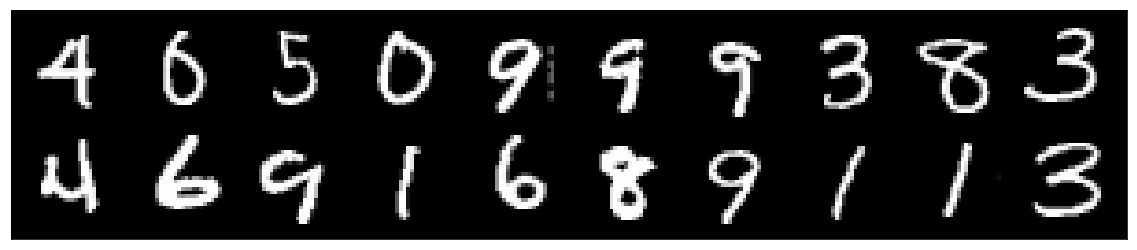

epoch = 25


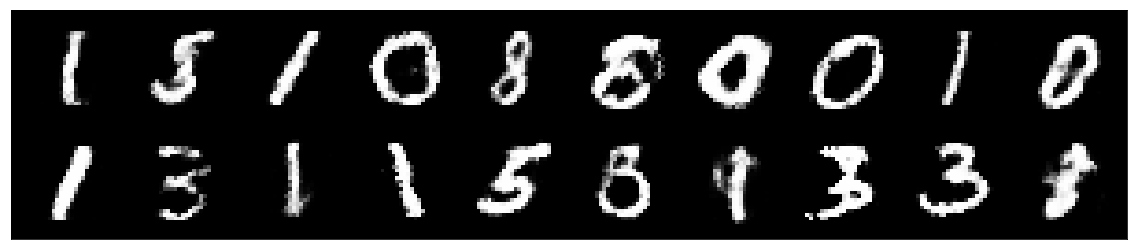

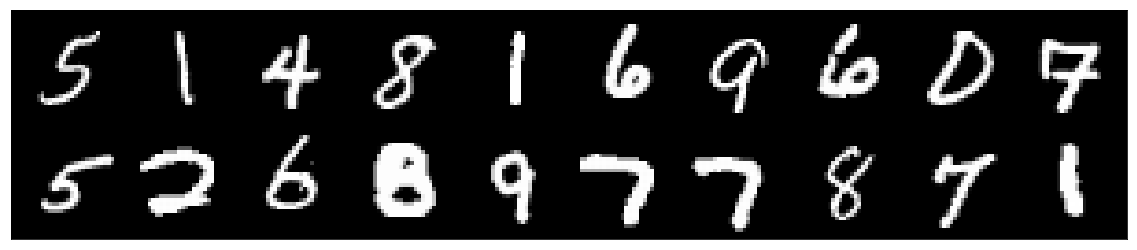

epoch = 26


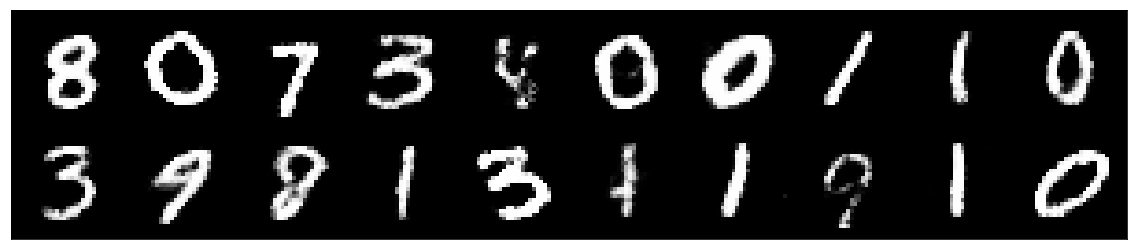

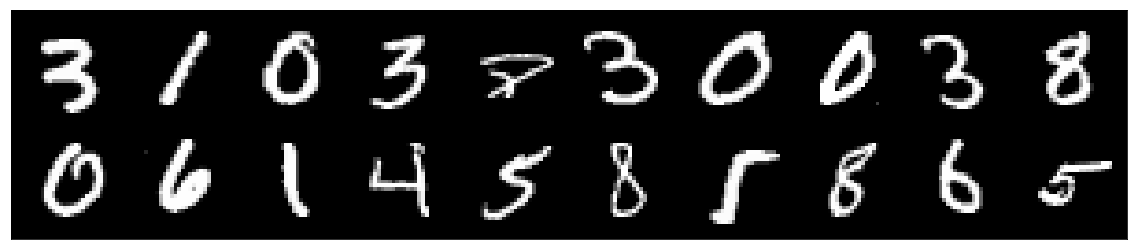

epoch = 27


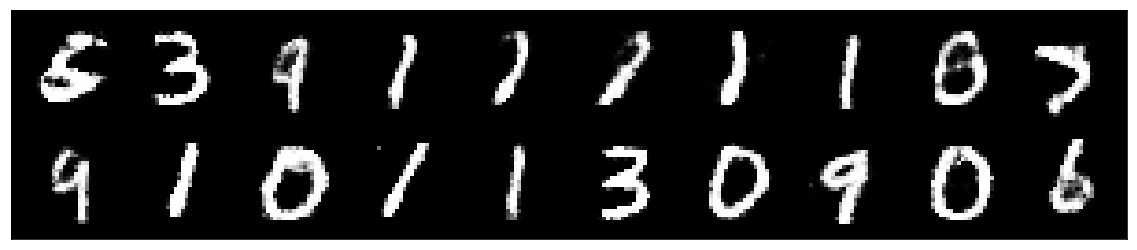

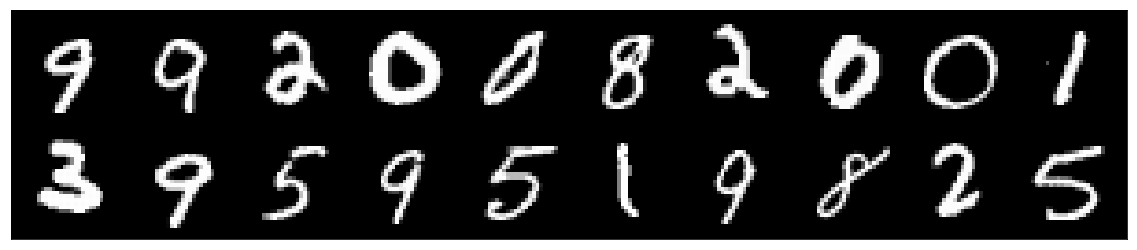

epoch = 28


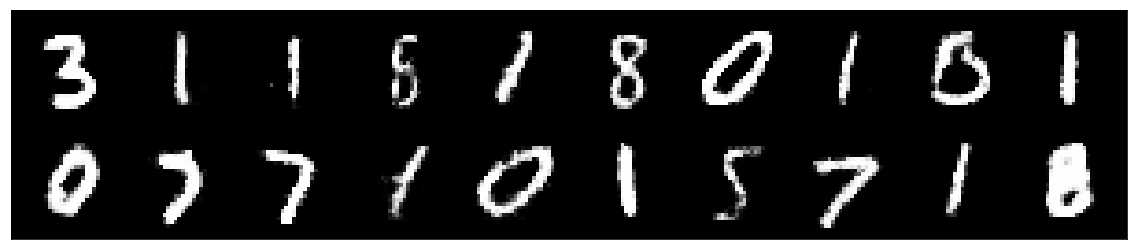

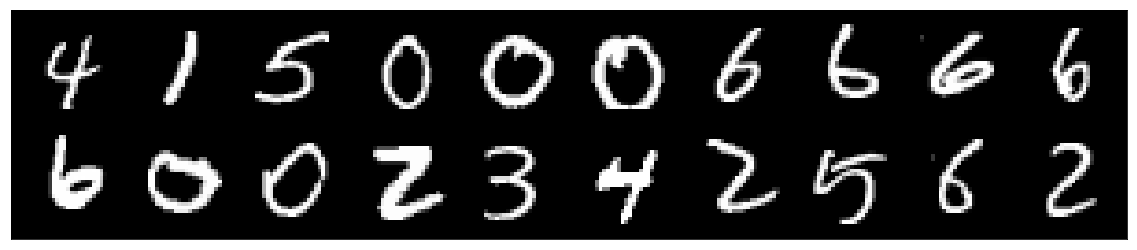

epoch = 29


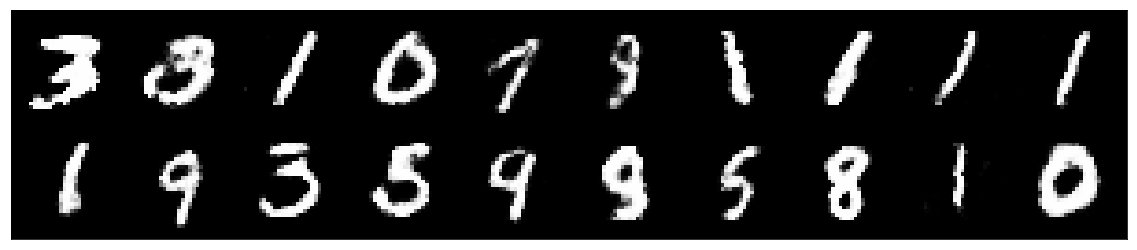

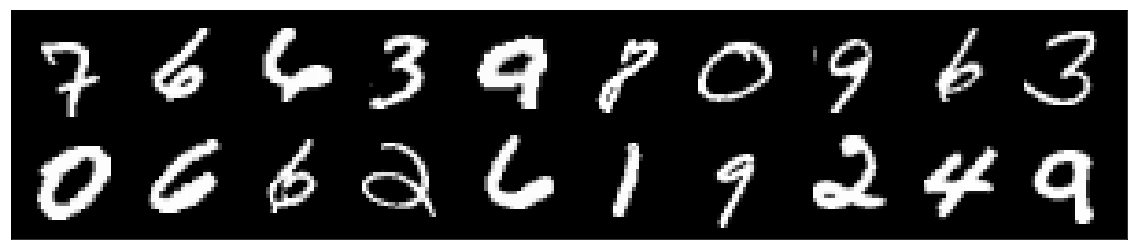

epoch = 30


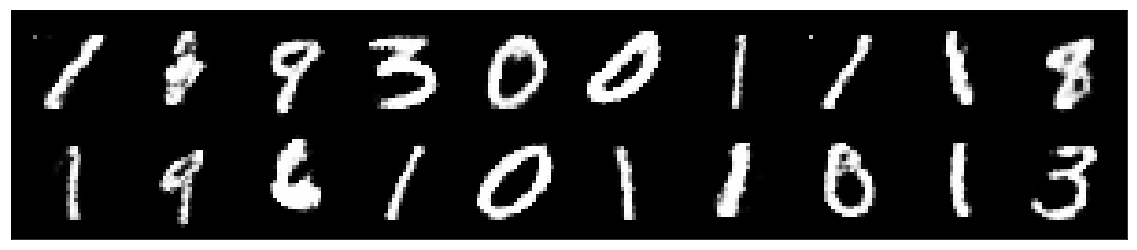

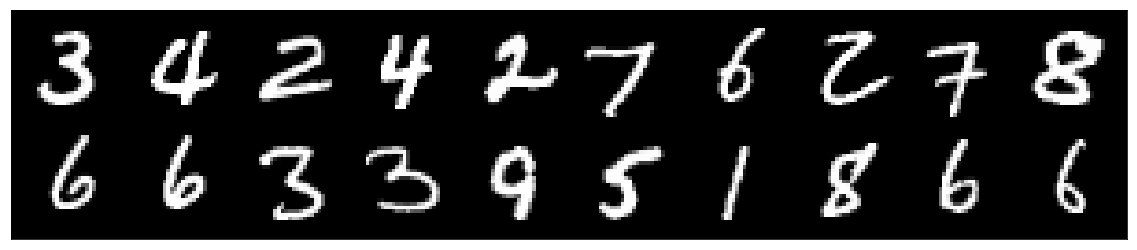

epoch = 31


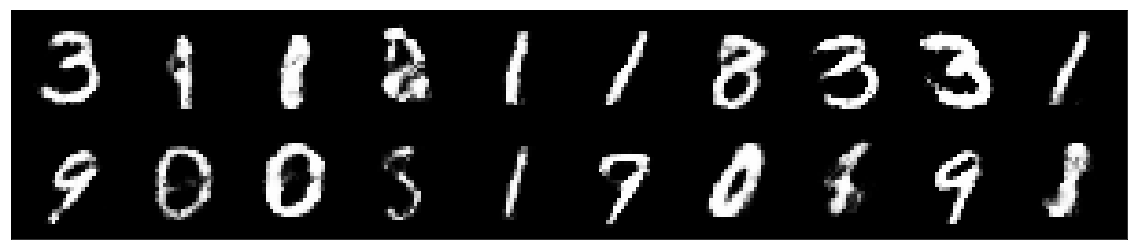

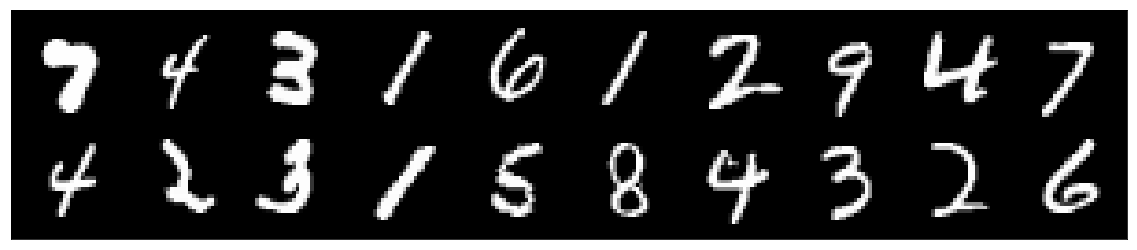

epoch = 32


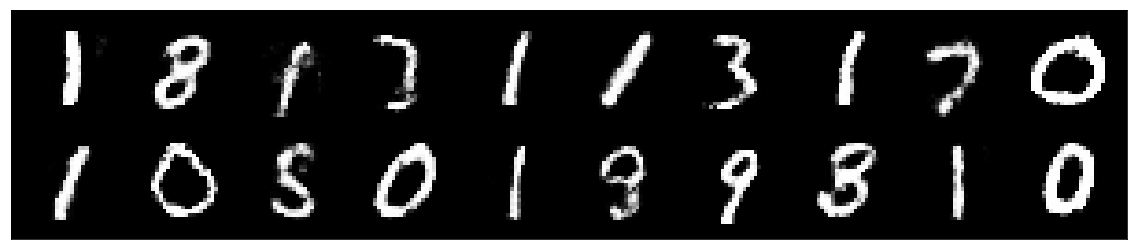

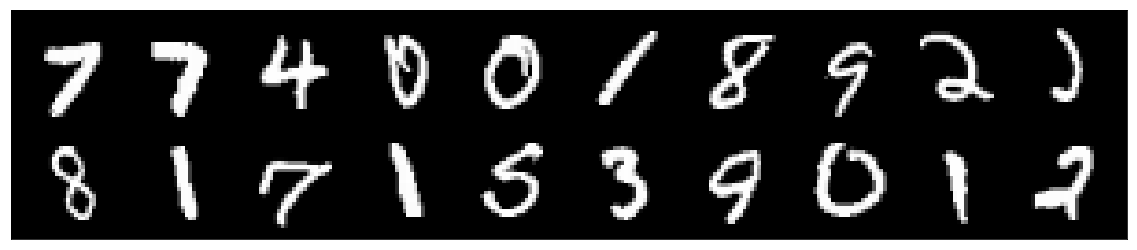

epoch = 33


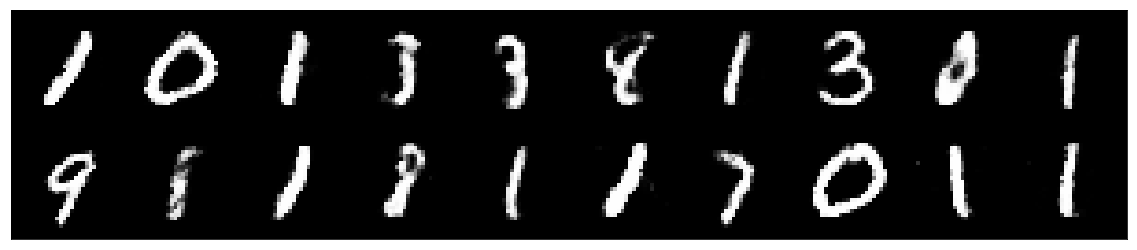

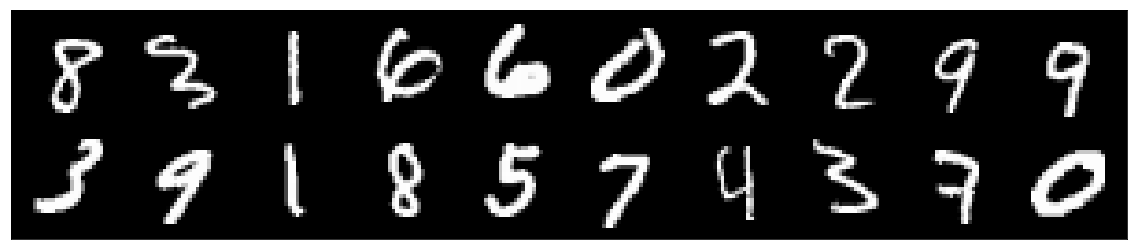

epoch = 34


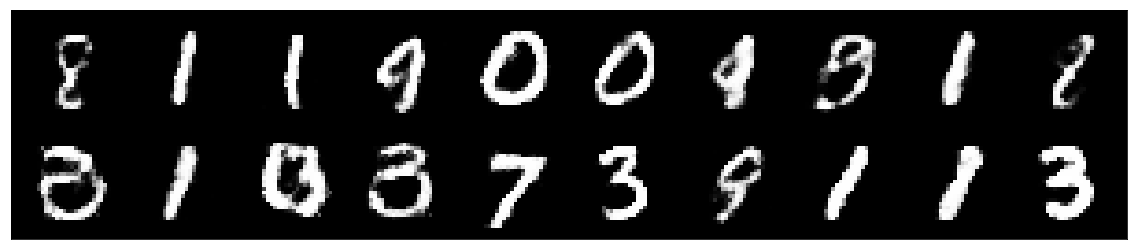

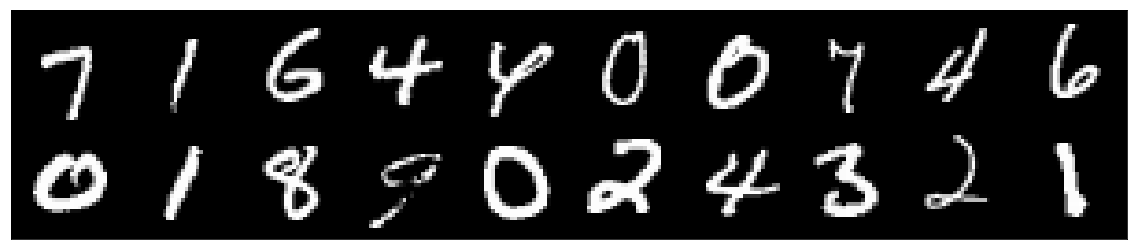

epoch = 35


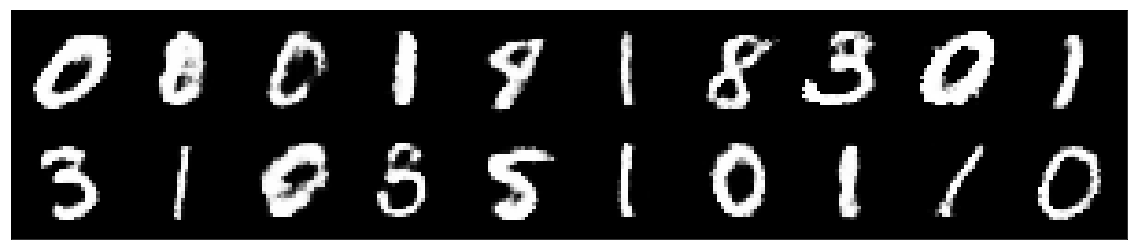

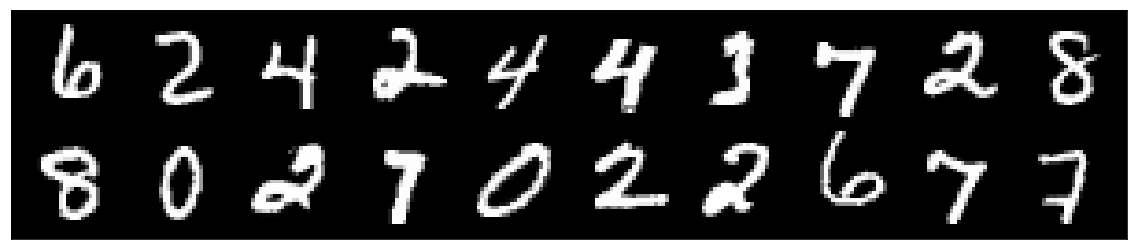

epoch = 36


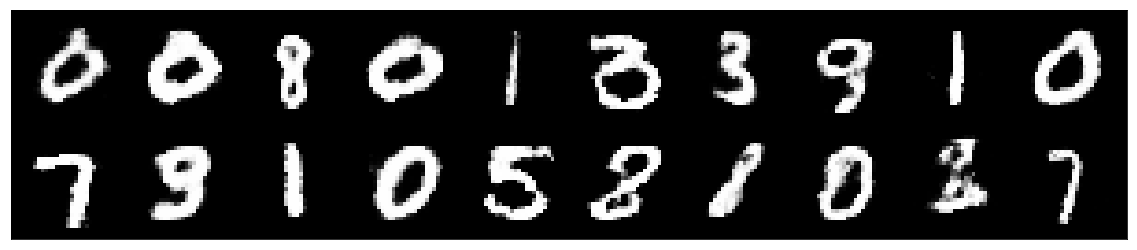

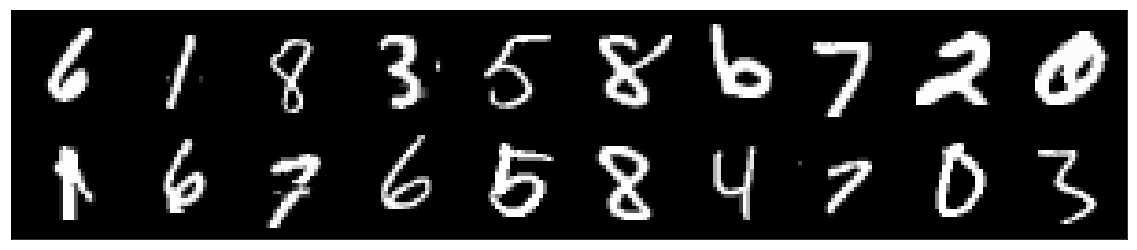

epoch = 37


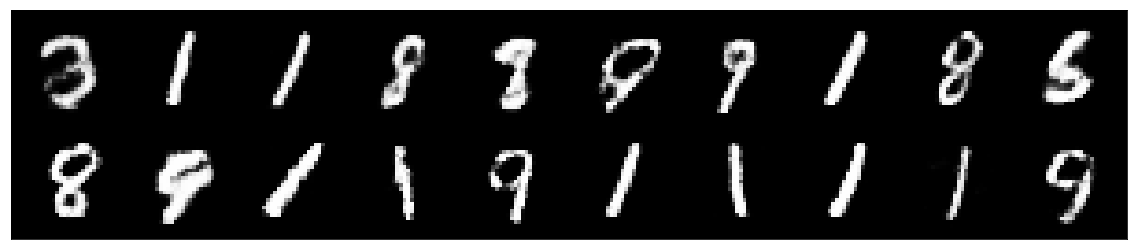

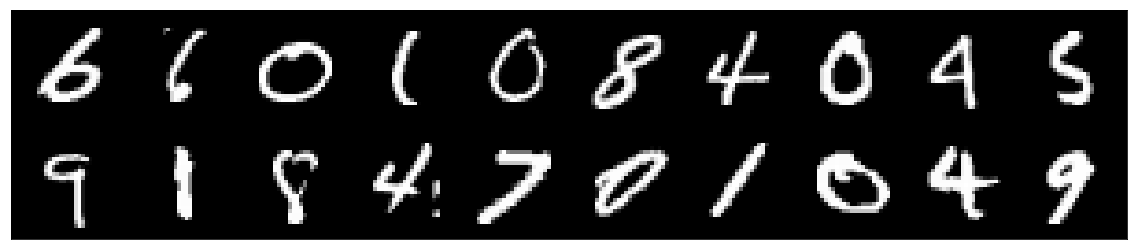

epoch = 38


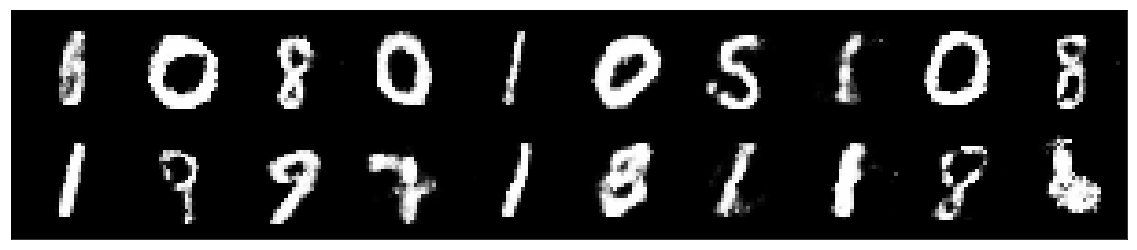

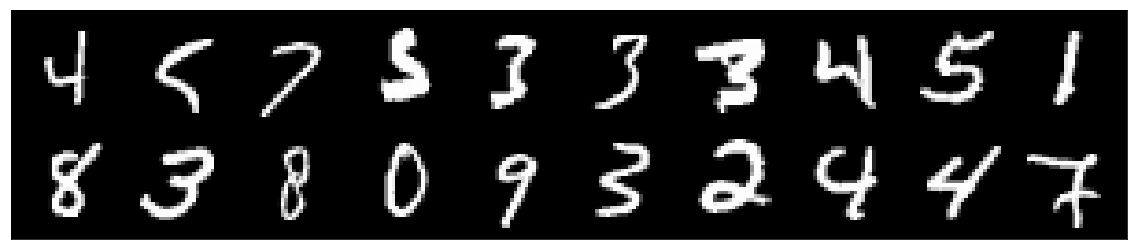

epoch = 39


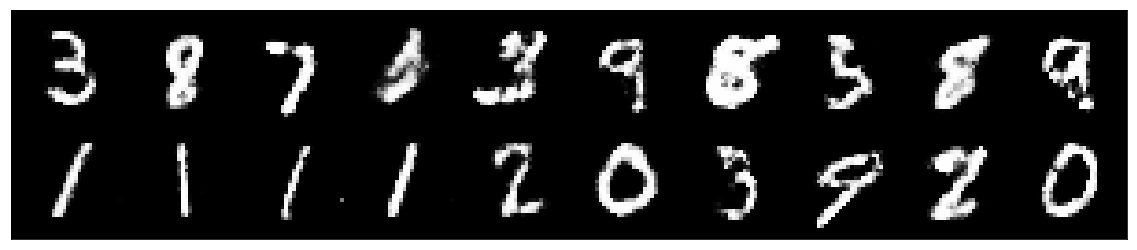

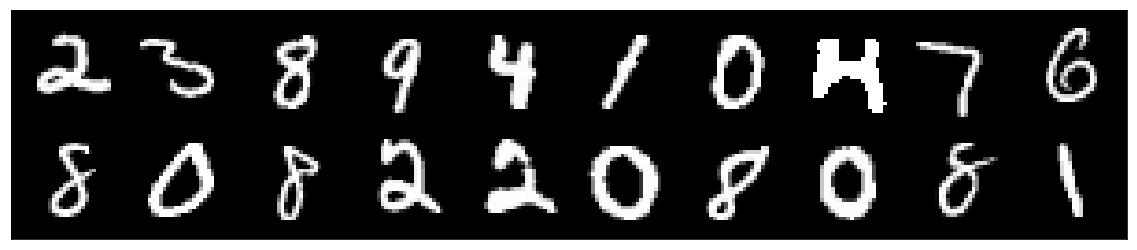

epoch = 40


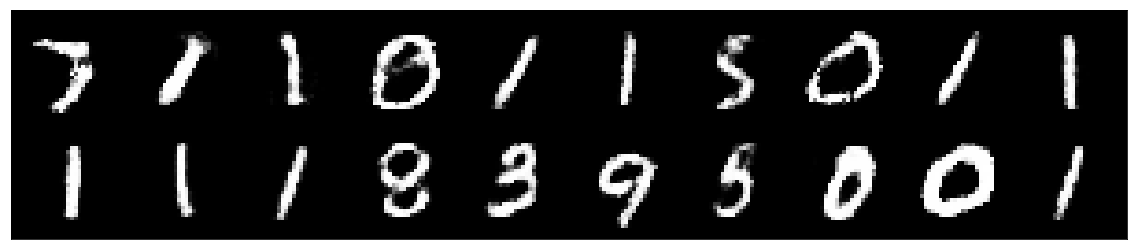

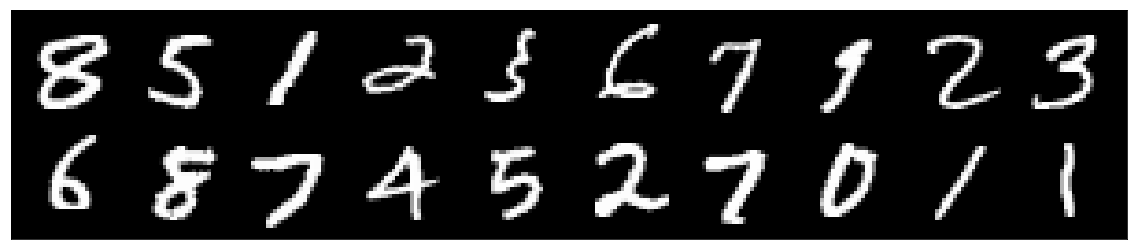

epoch = 41


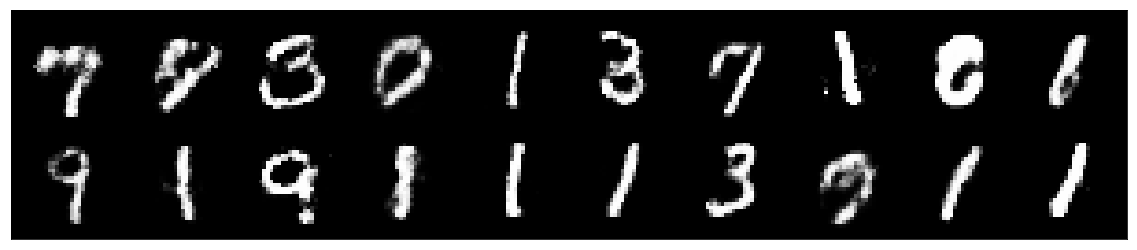

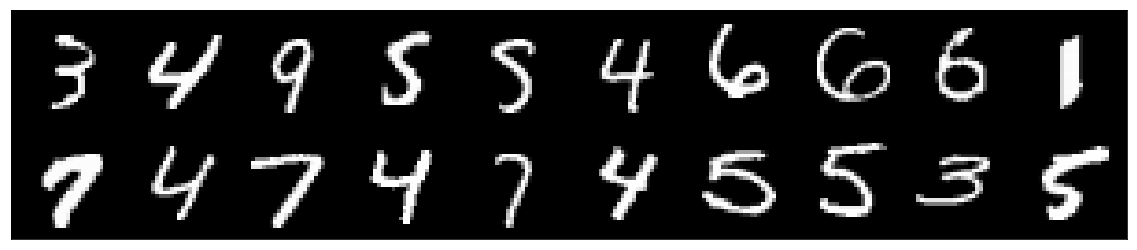

epoch = 42


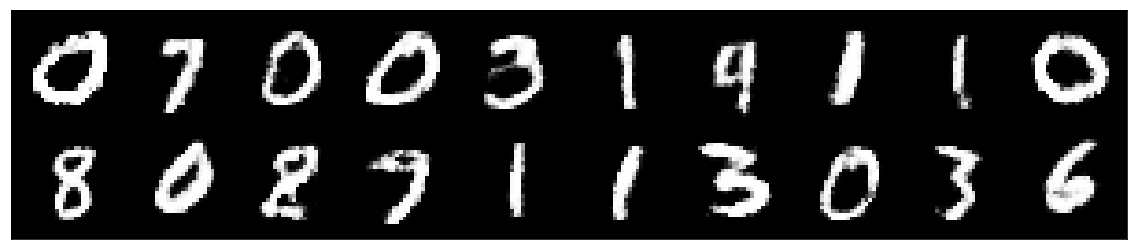

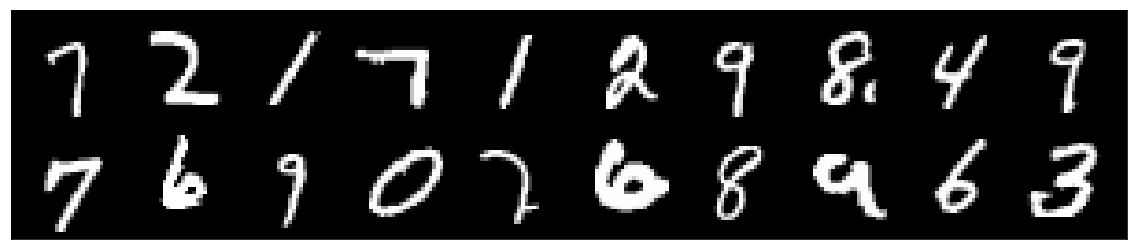

epoch = 43


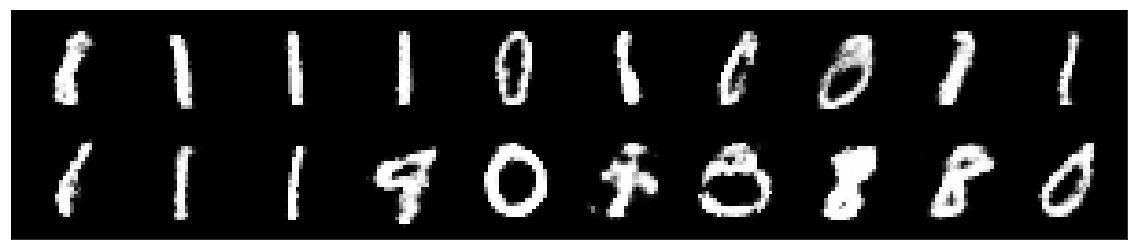

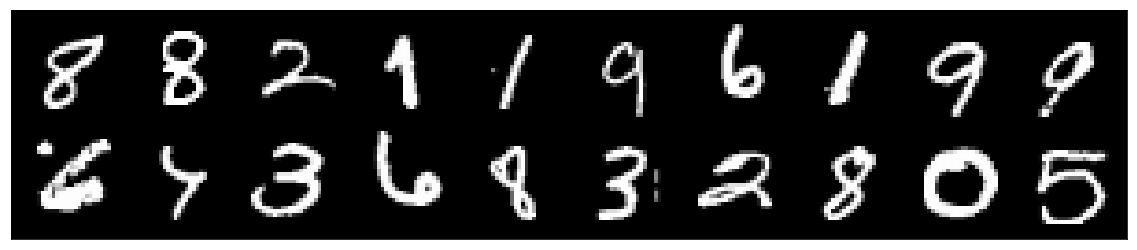

epoch = 44


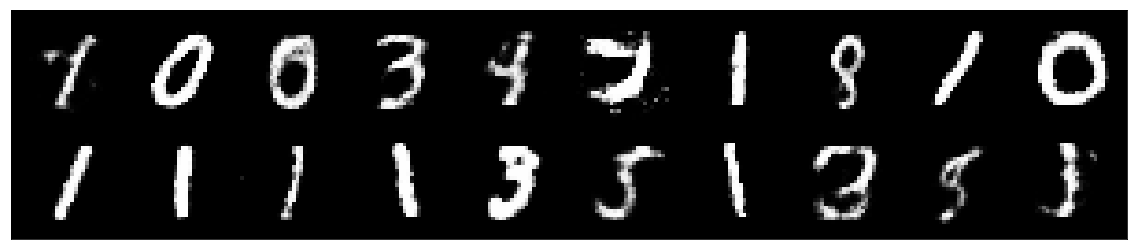

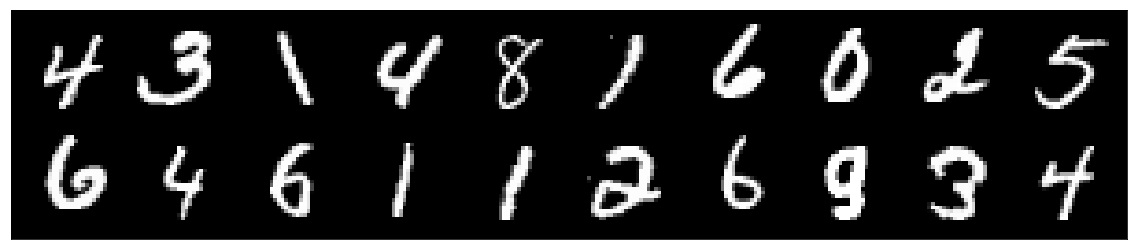

epoch = 45


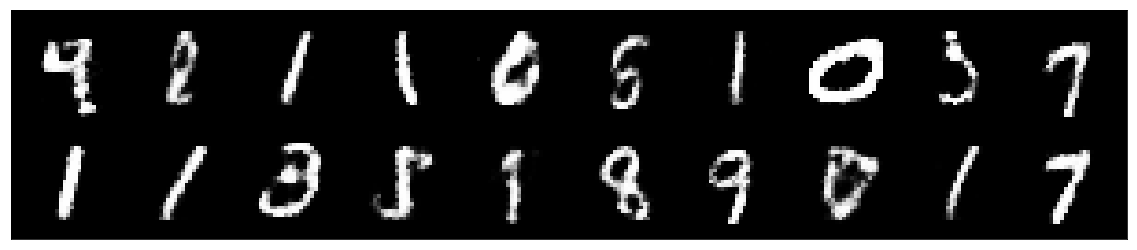

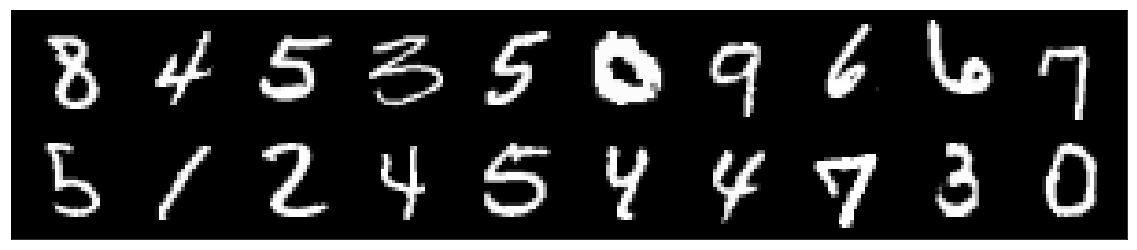

epoch = 46


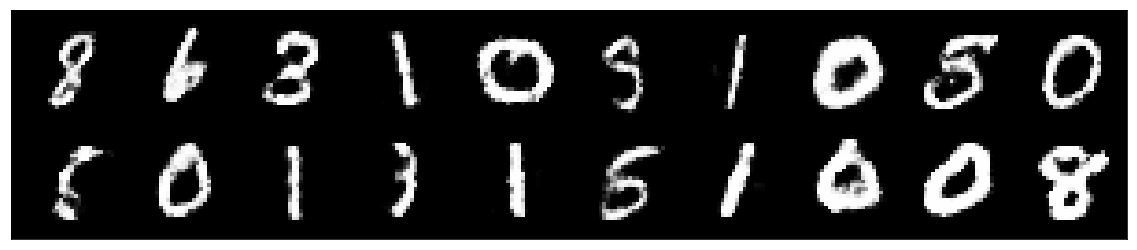

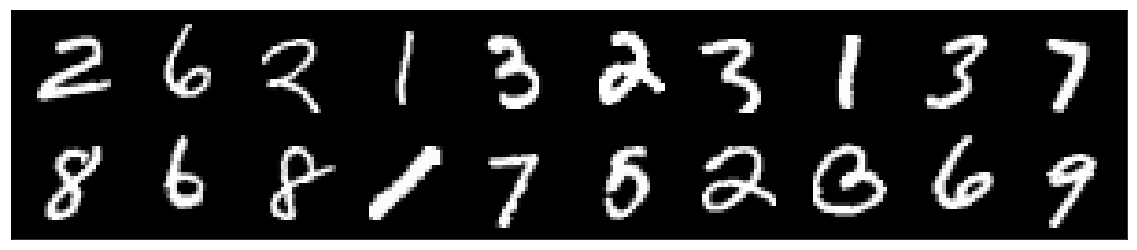

epoch = 47


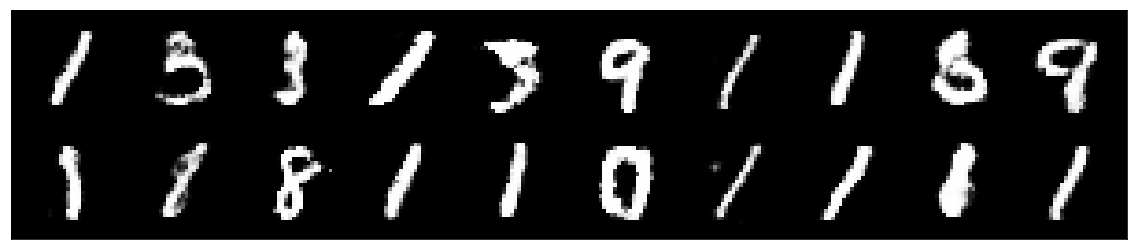

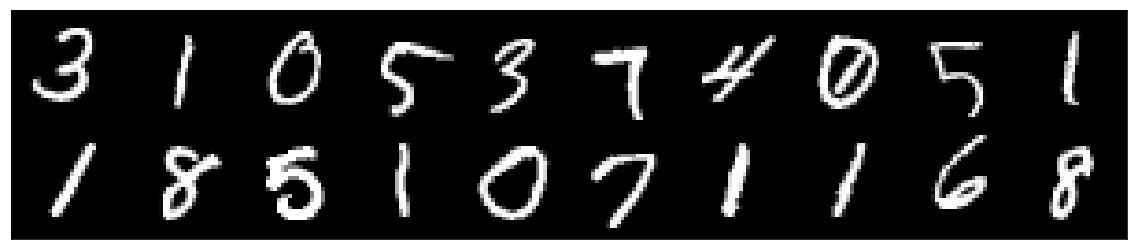

epoch = 48


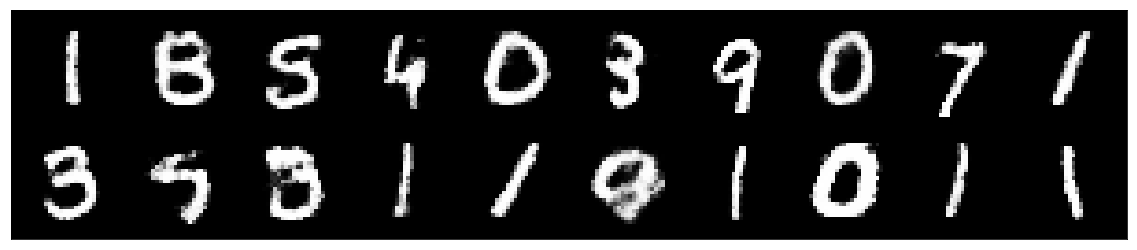

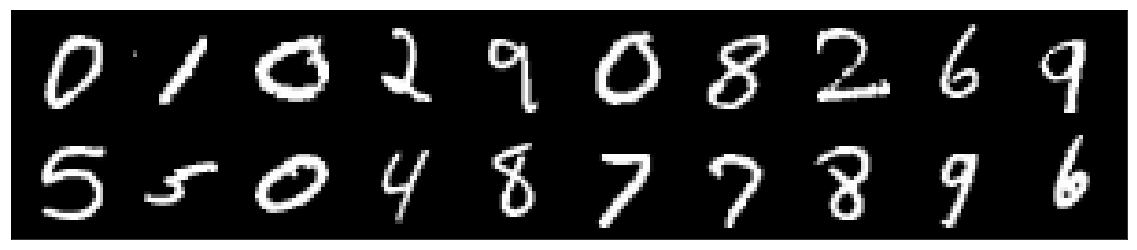

epoch = 49


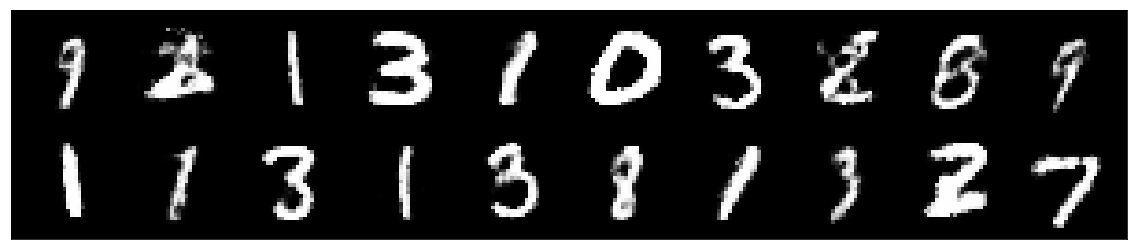

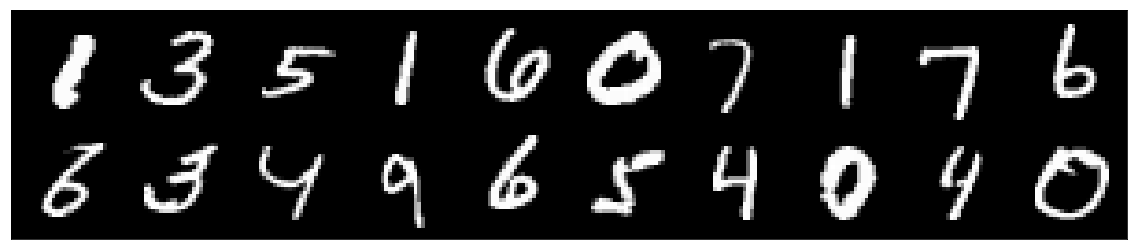

epoch = 50


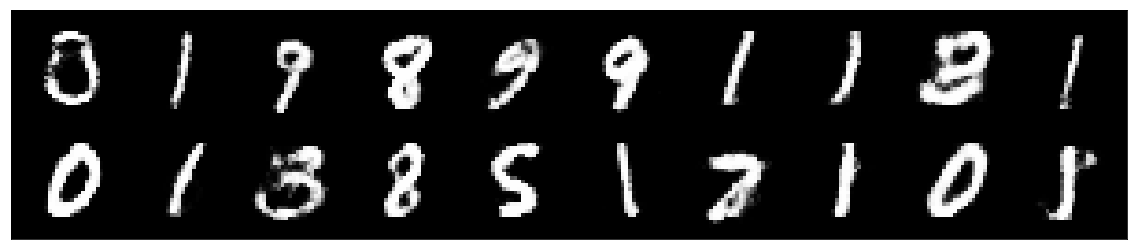

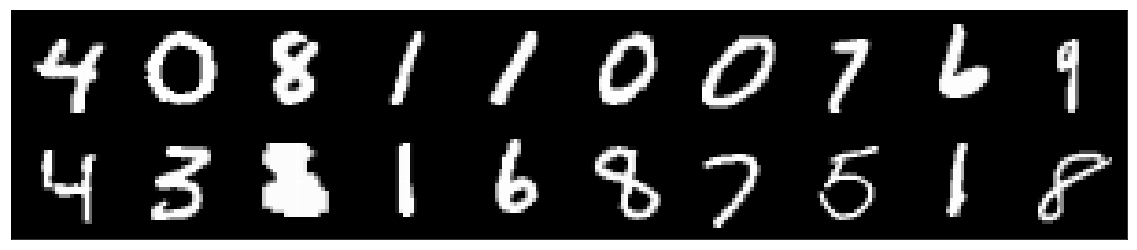

epoch = 51


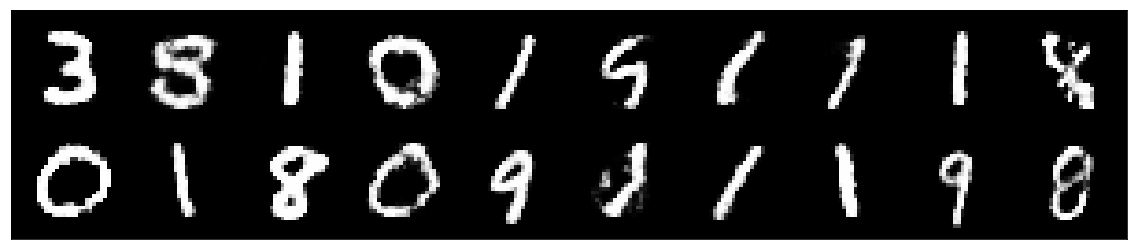

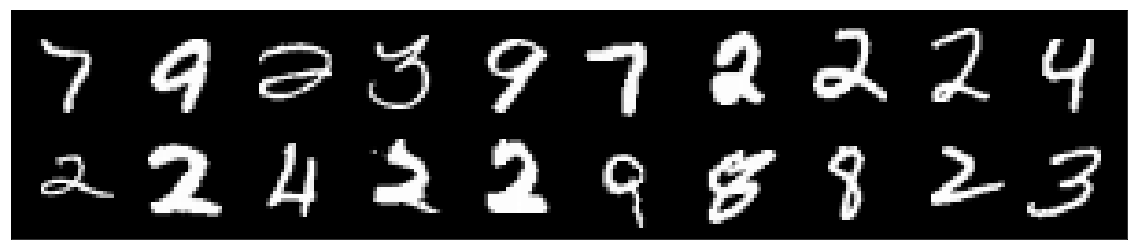

epoch = 52


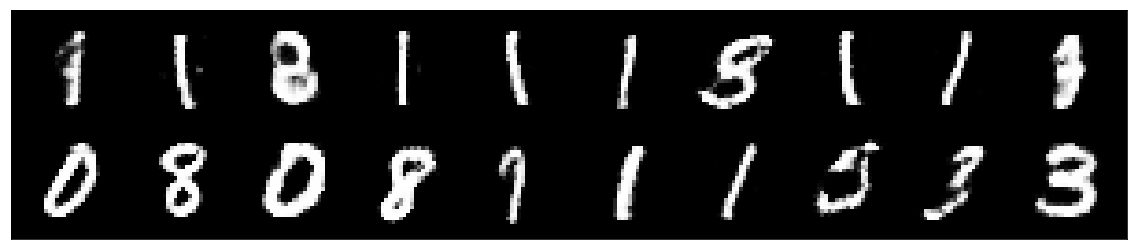

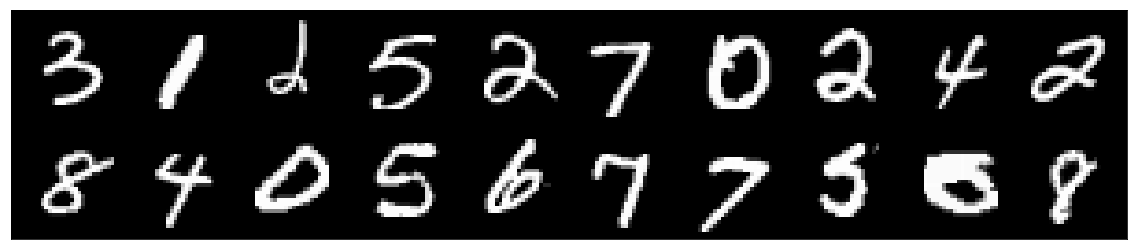

epoch = 53


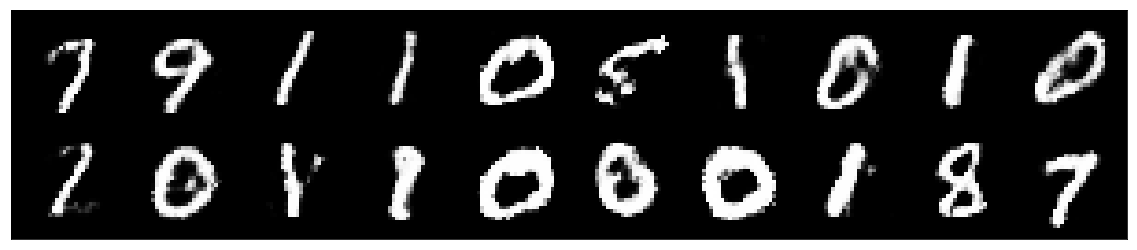

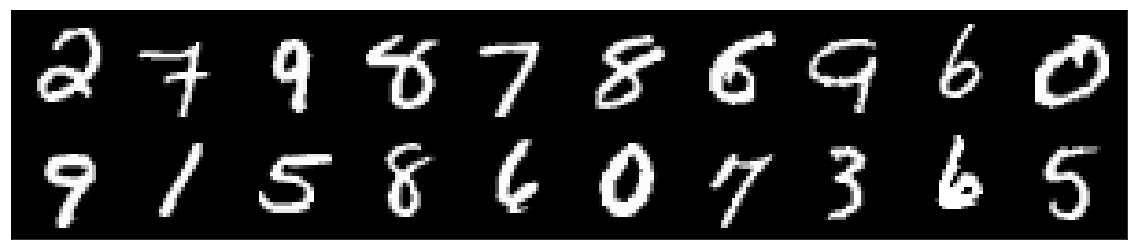

epoch = 54


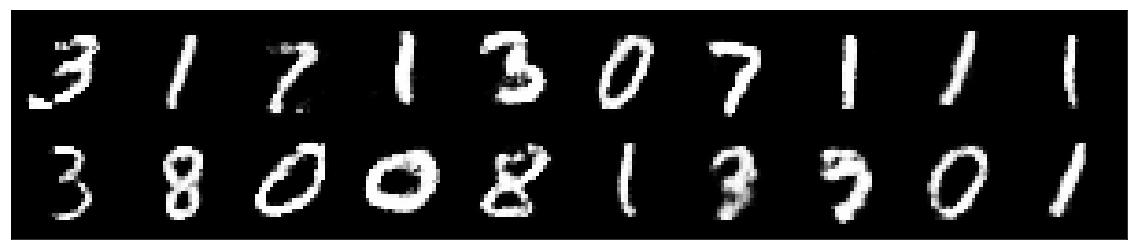

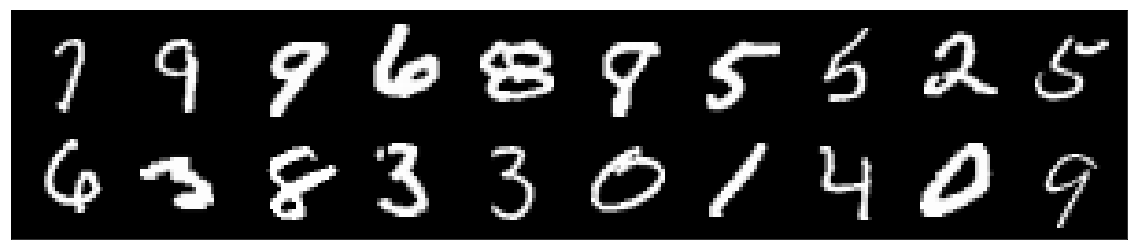

epoch = 55


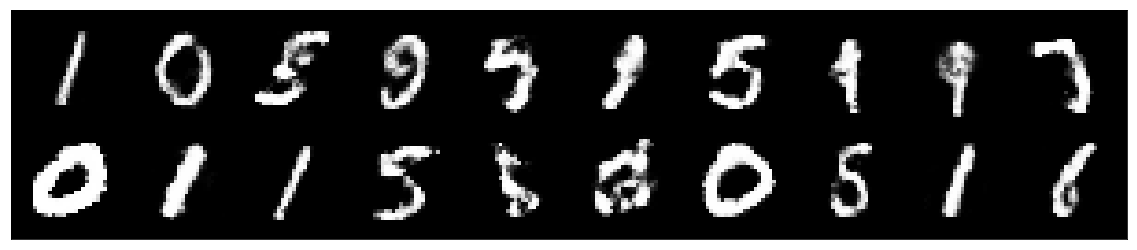

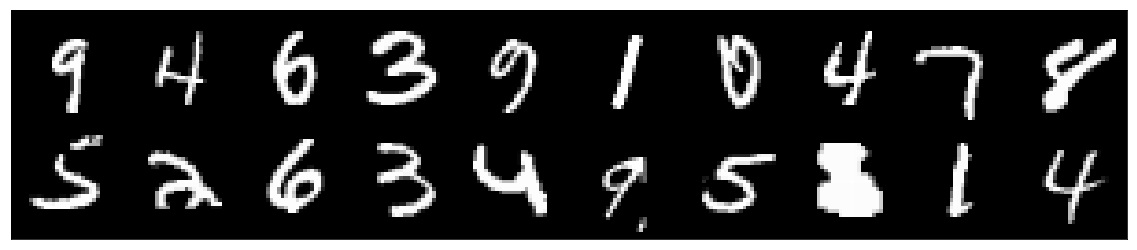

epoch = 56


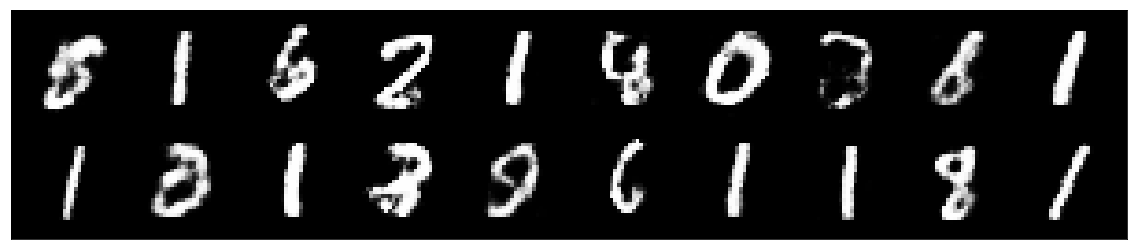

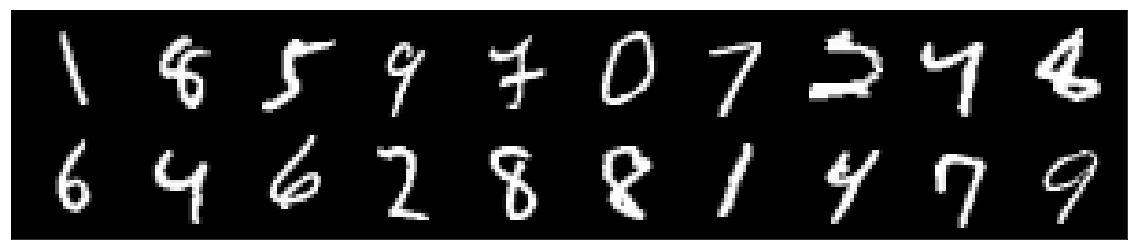

epoch = 57


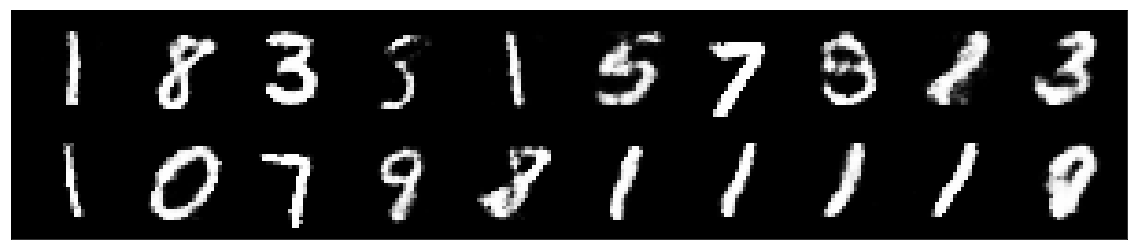

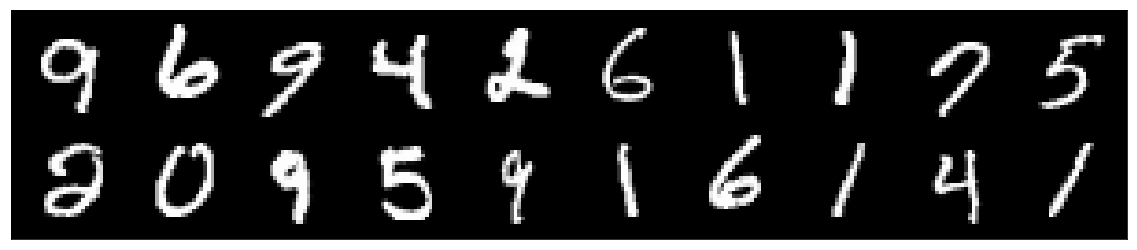

epoch = 58


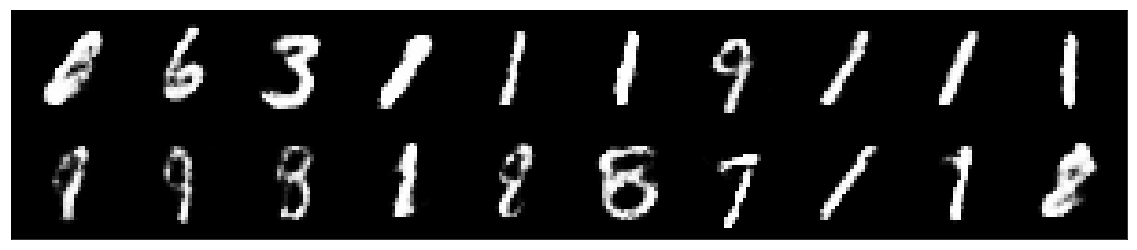

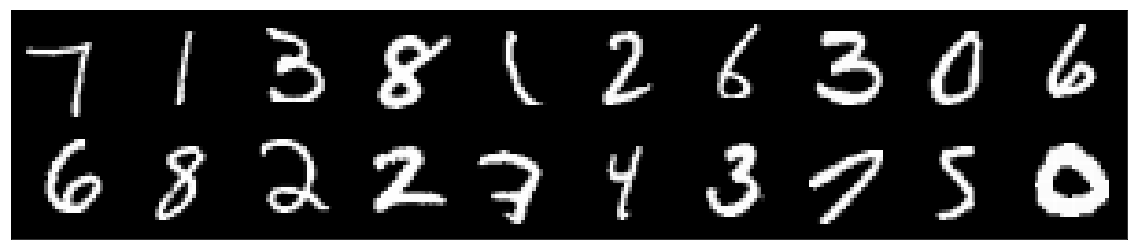

epoch = 59


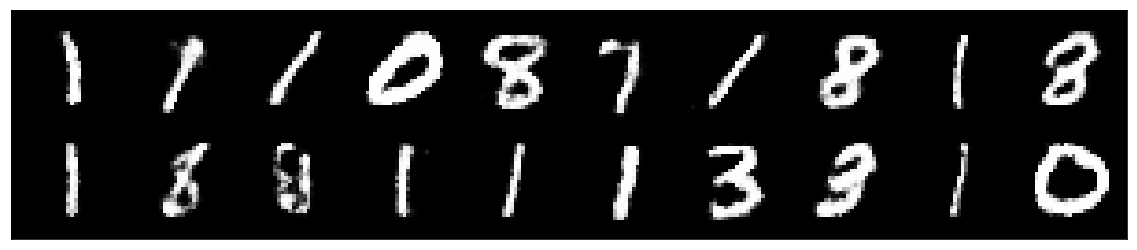

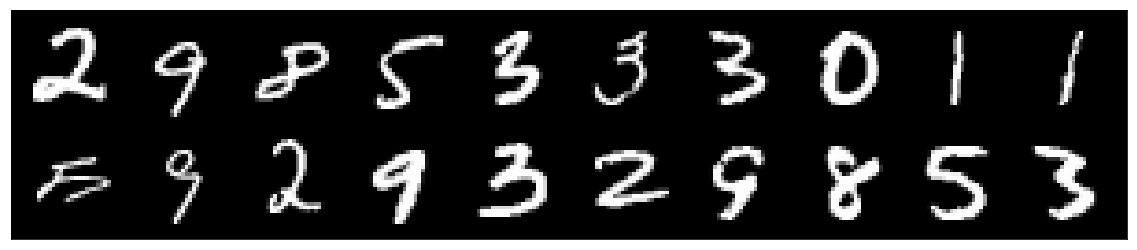

epoch = 60


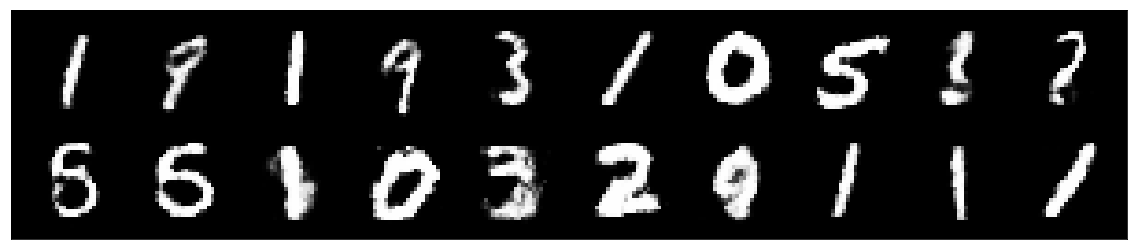

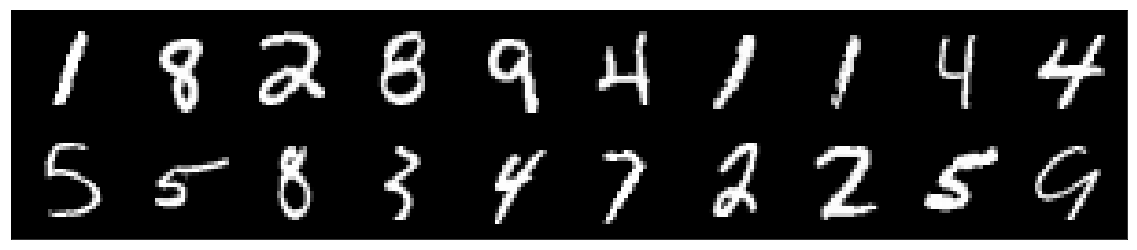

epoch = 61


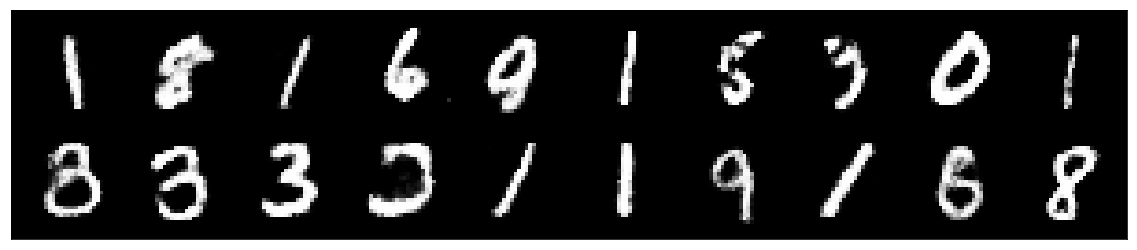

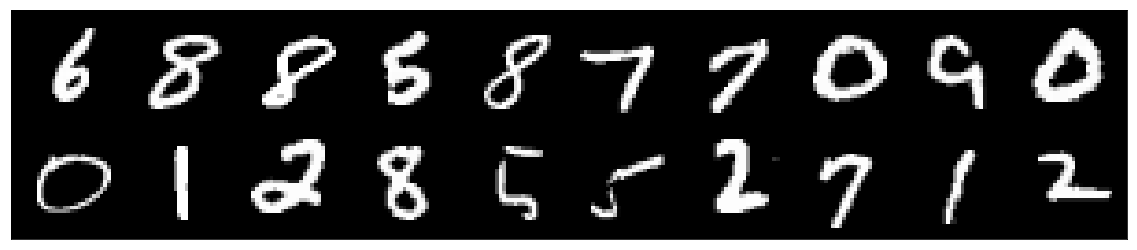

epoch = 62


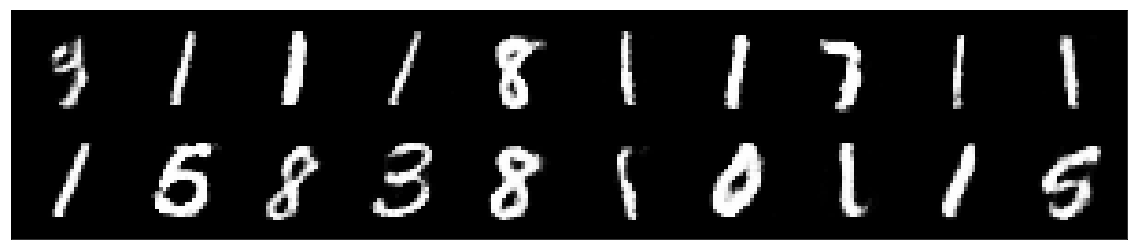

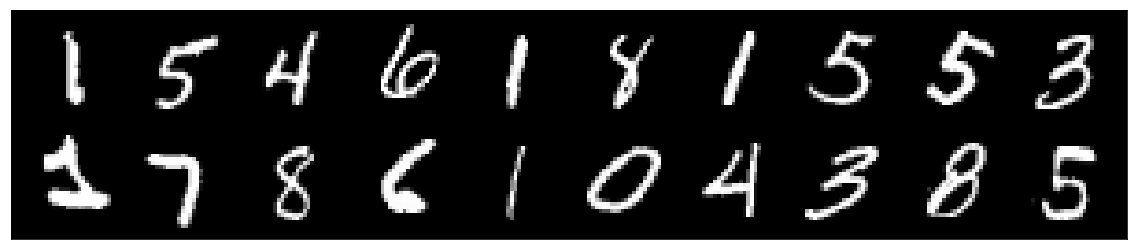

epoch = 63


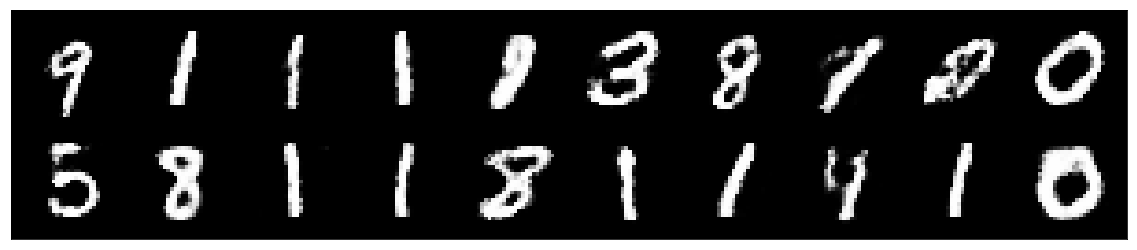

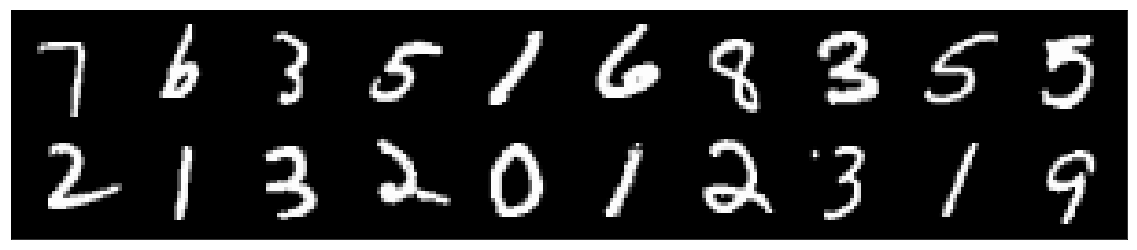

epoch = 64


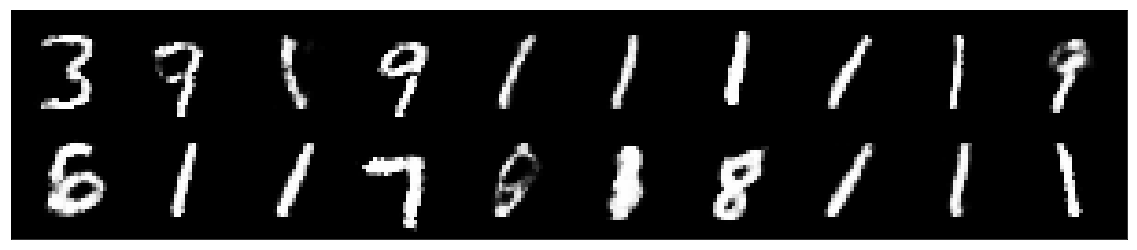

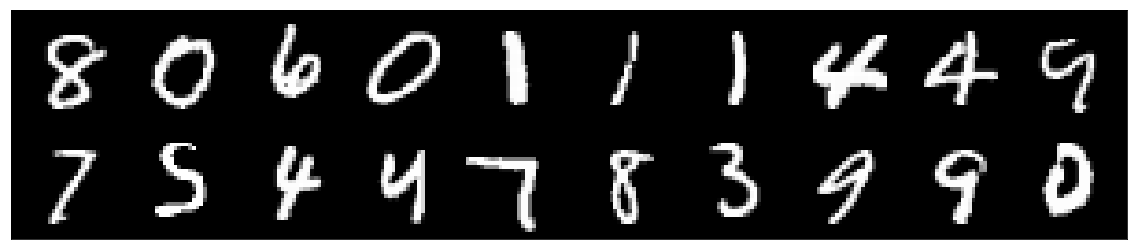

epoch = 65


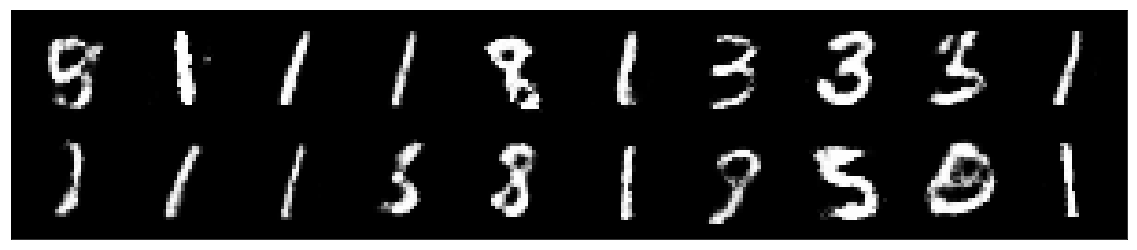

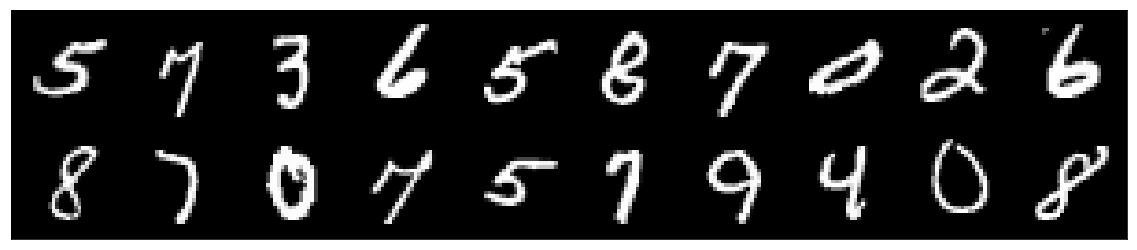

epoch = 66


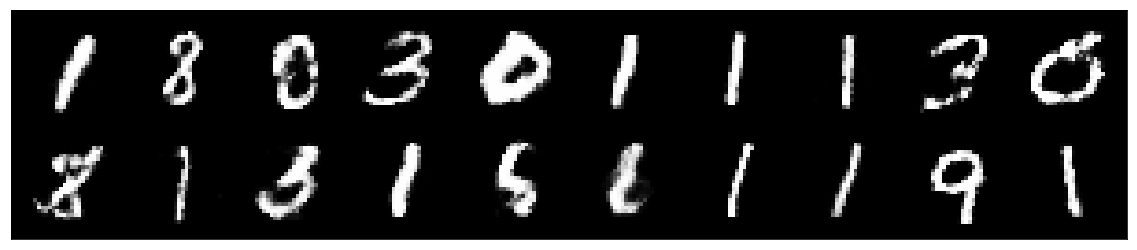

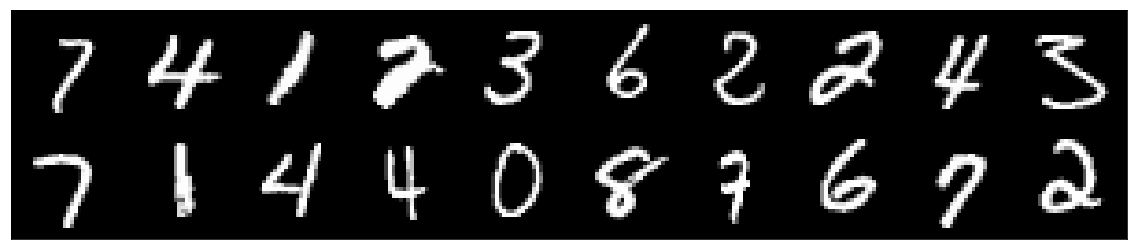

epoch = 67


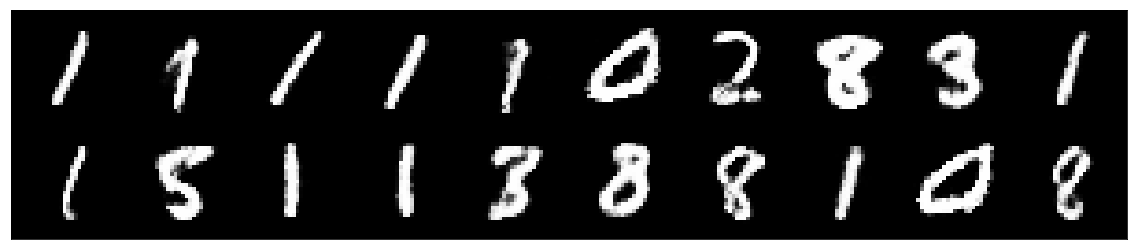

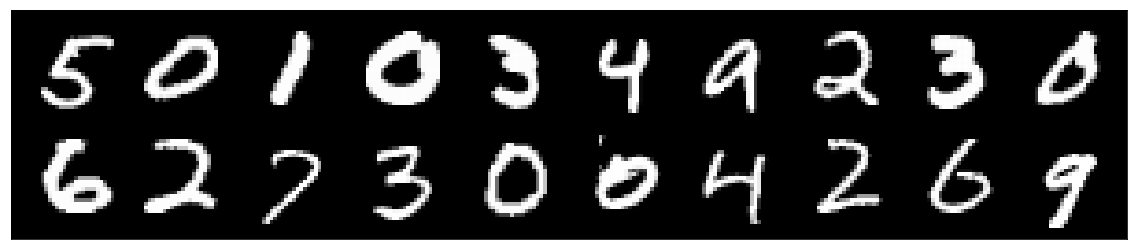

epoch = 68


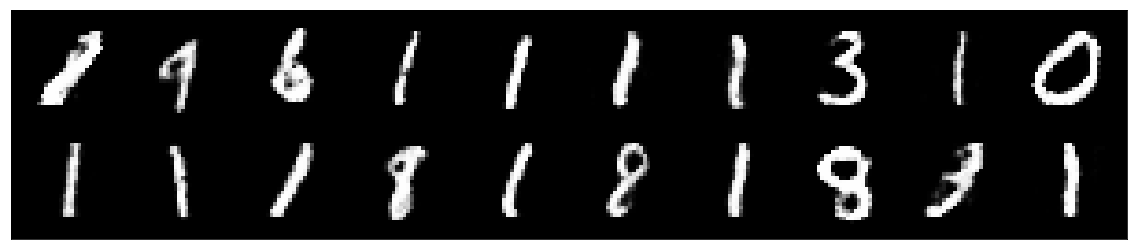

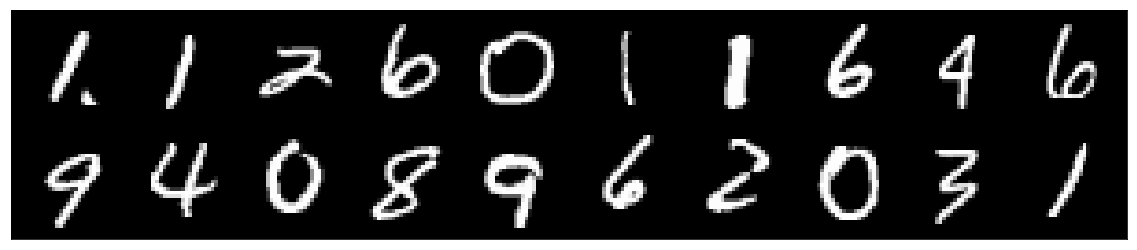

epoch = 69


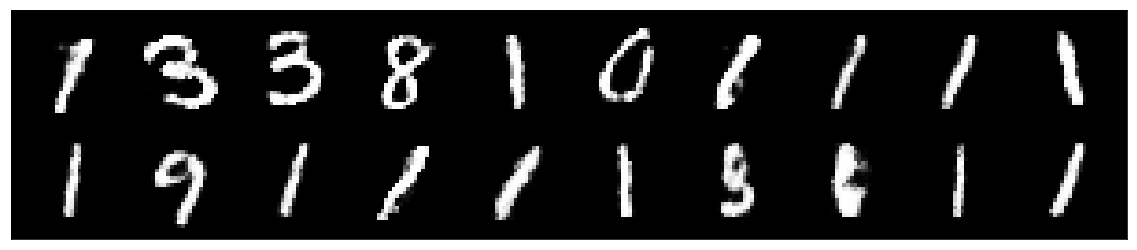

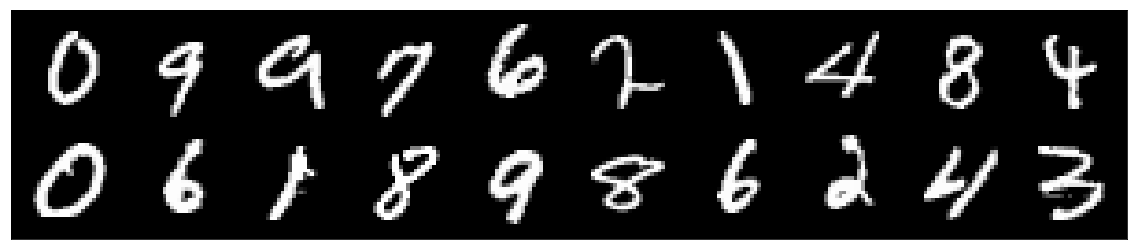

epoch = 70


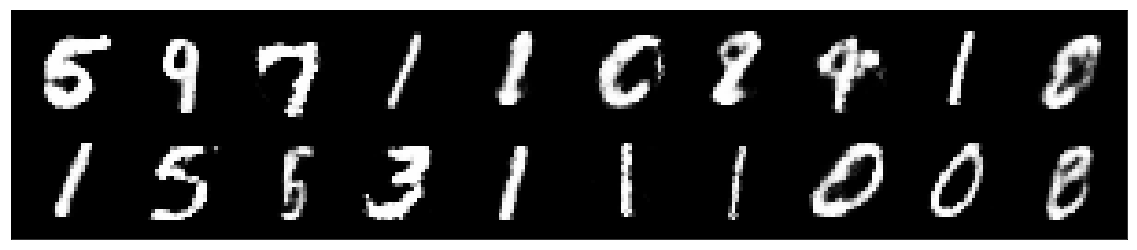

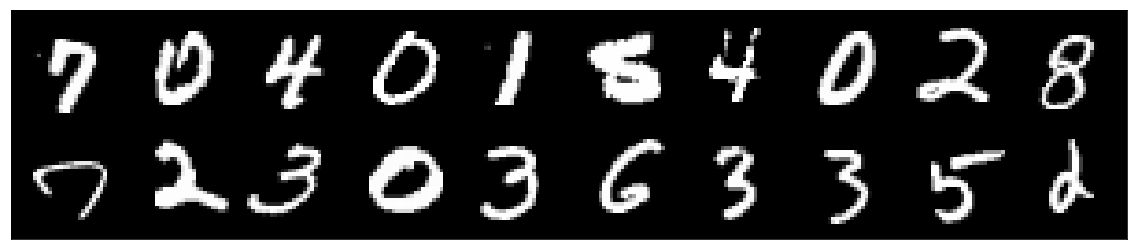

epoch = 71


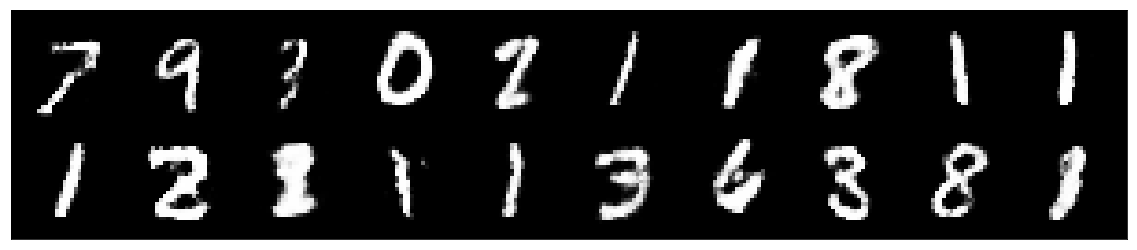

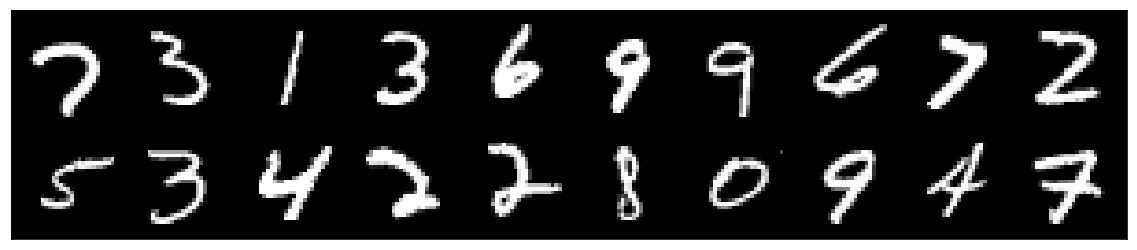

epoch = 72


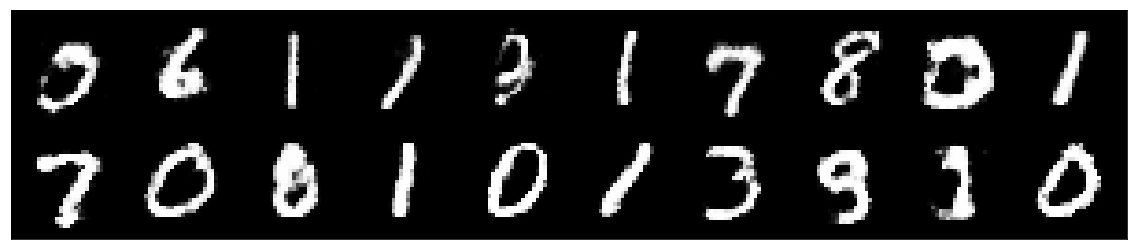

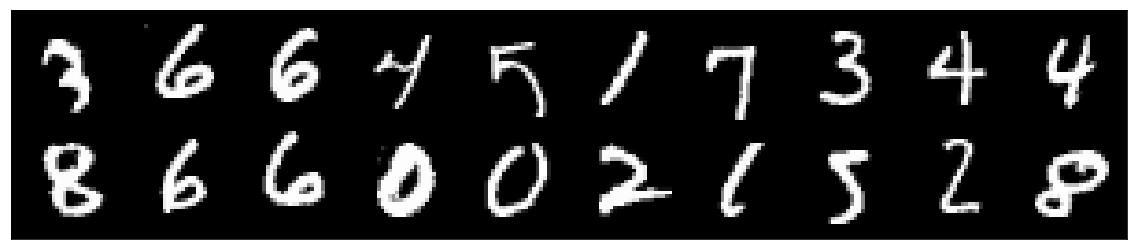

epoch = 73


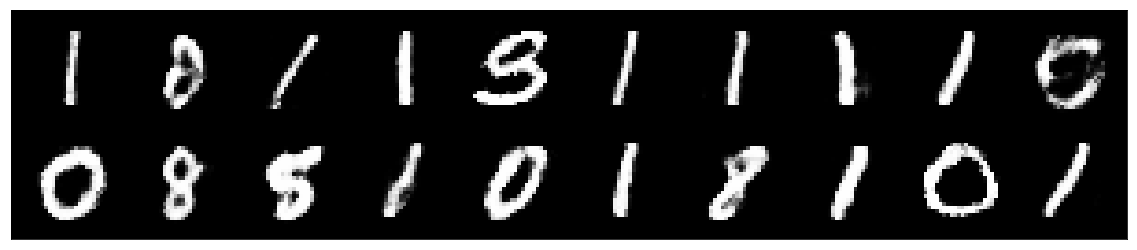

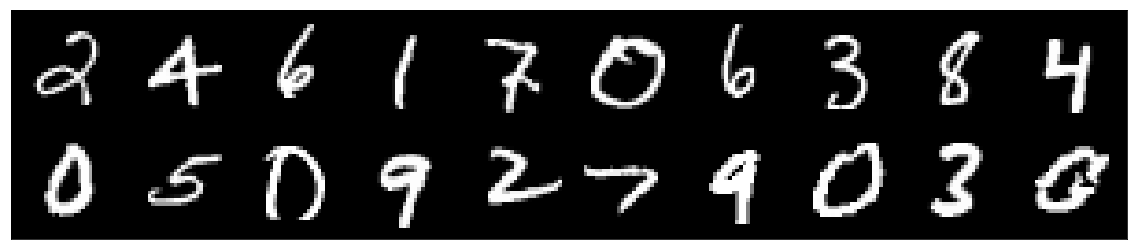

epoch = 74


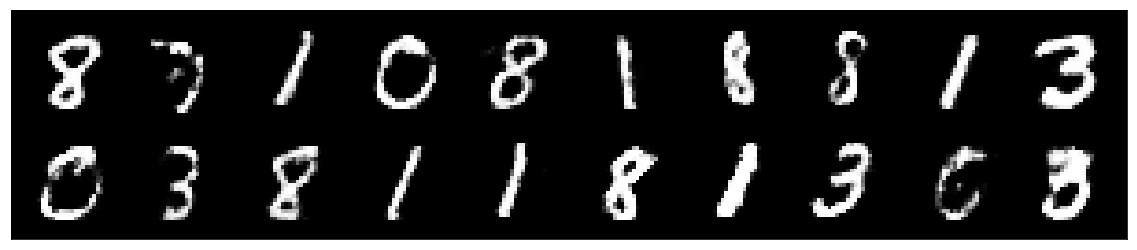

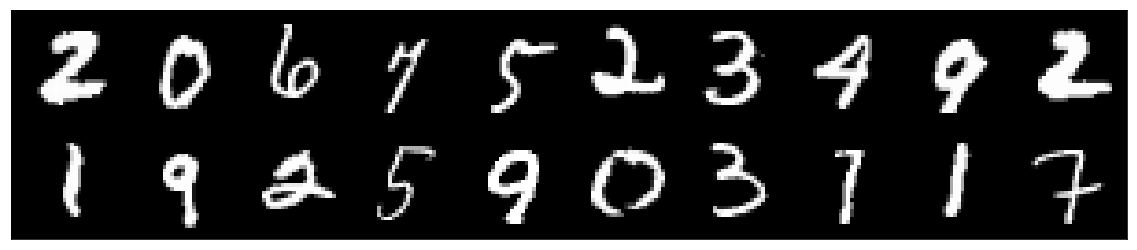

epoch = 75


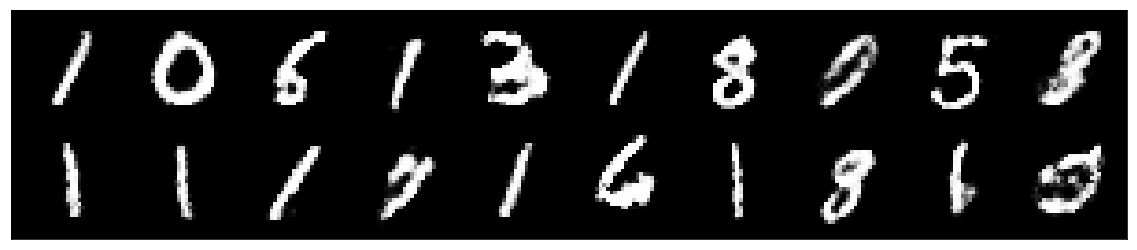

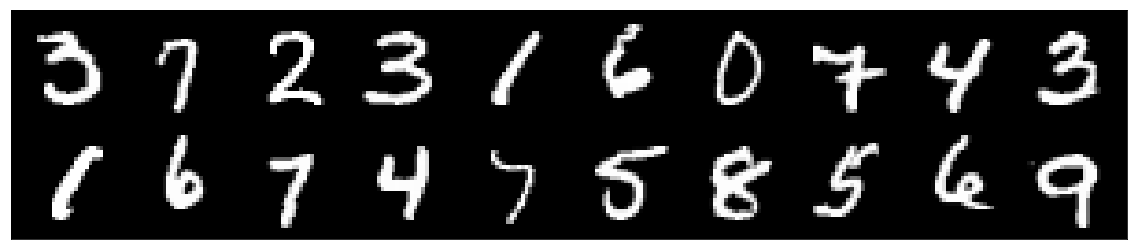

epoch = 76


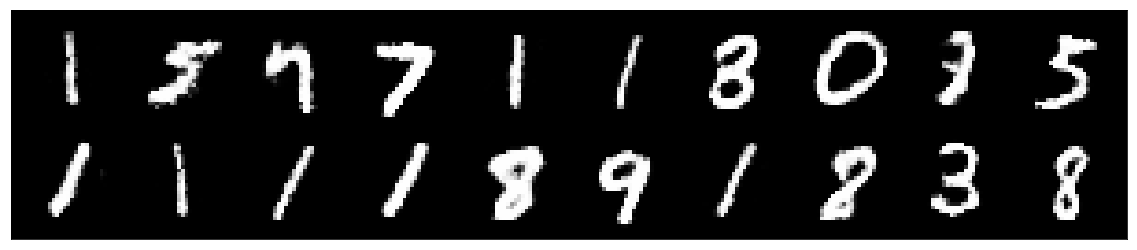

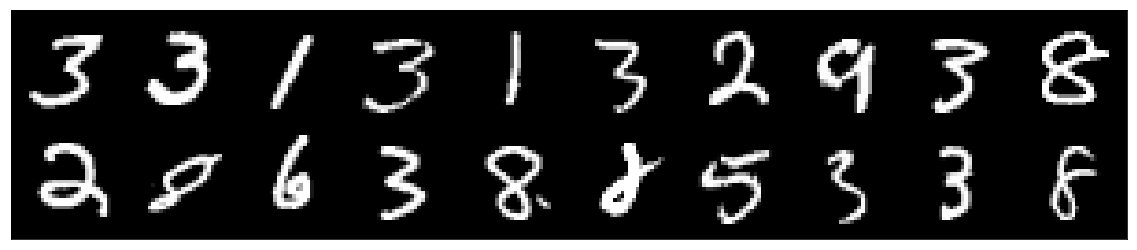

epoch = 77


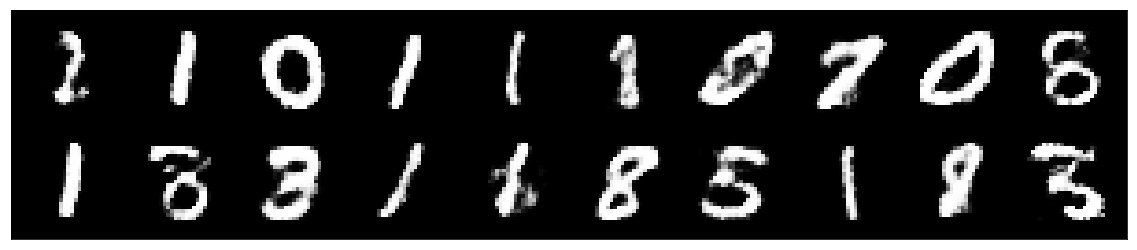

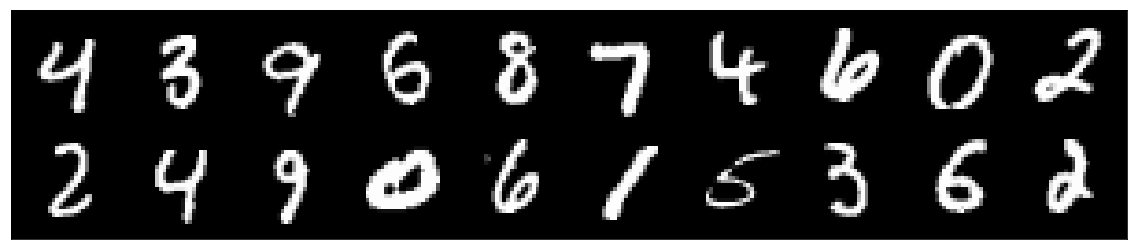

epoch = 78


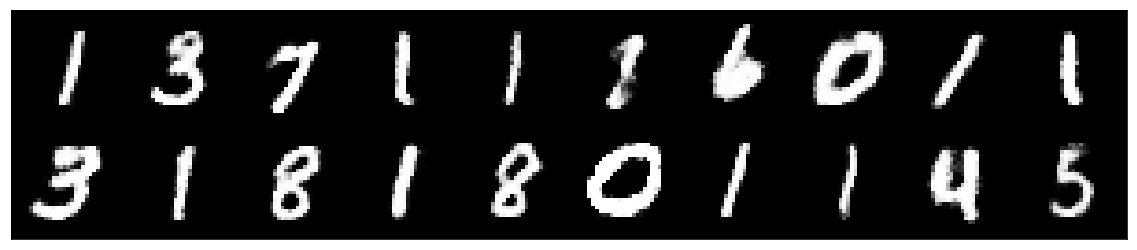

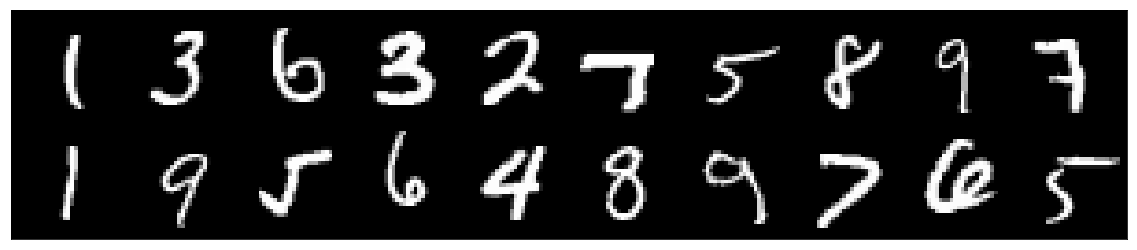

epoch = 79


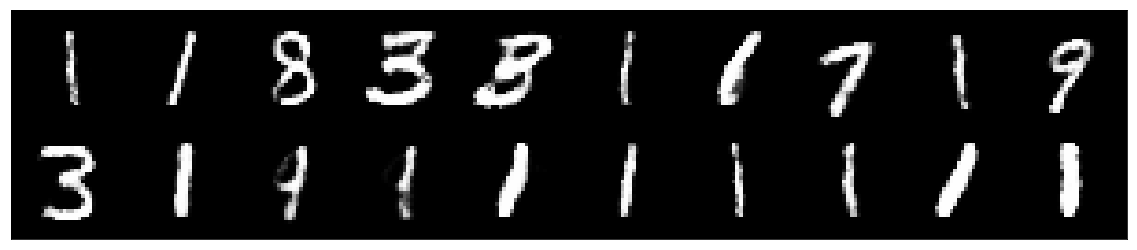

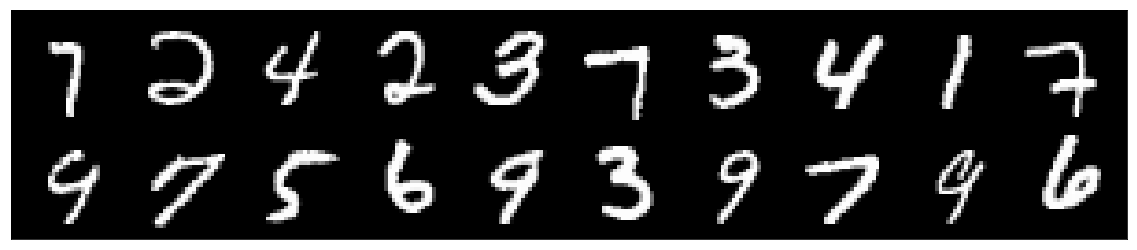

epoch = 80


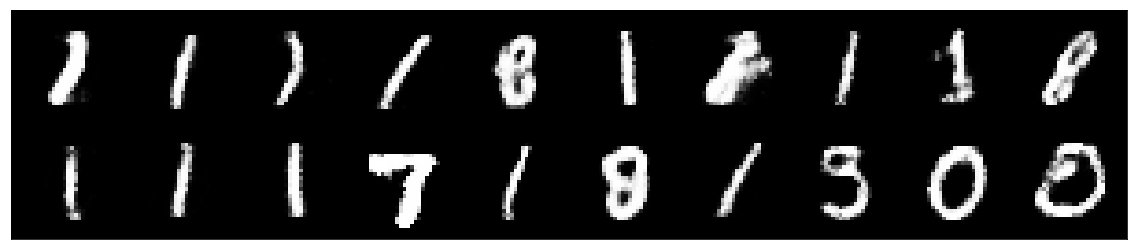

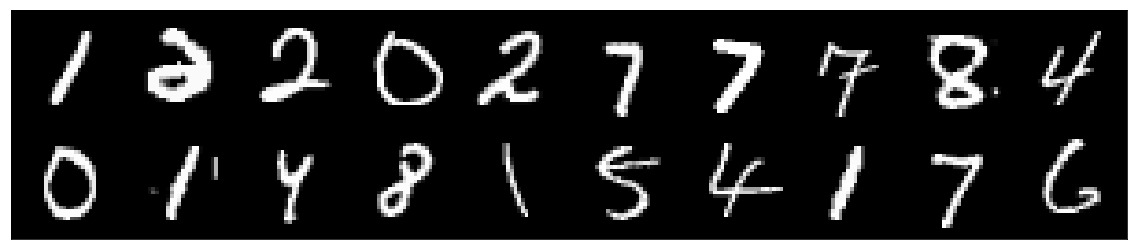

epoch = 81


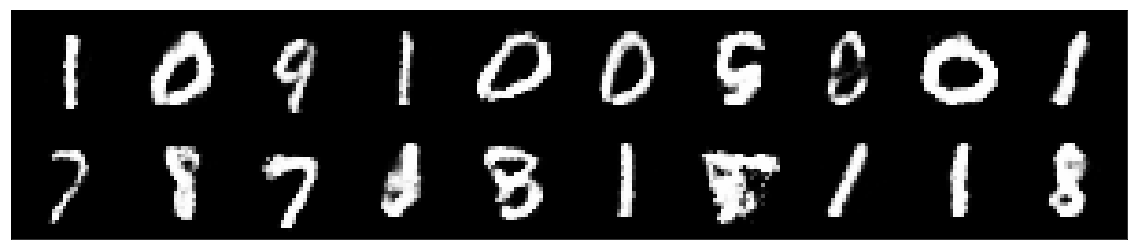

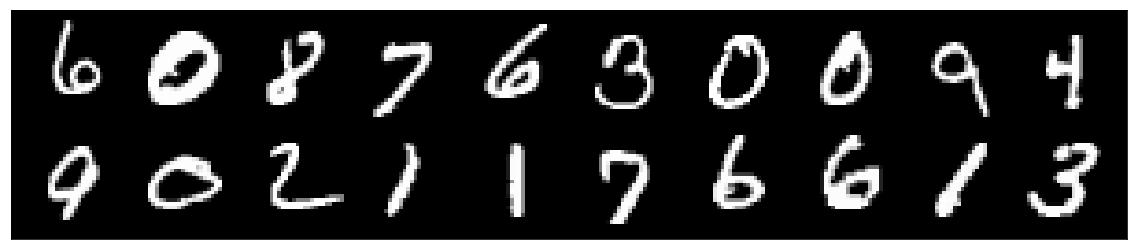

epoch = 82


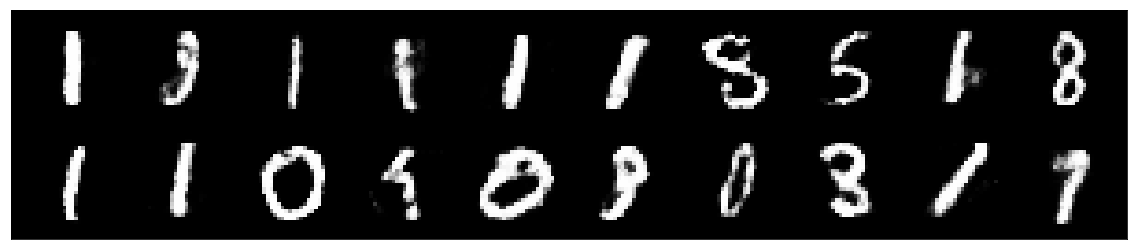

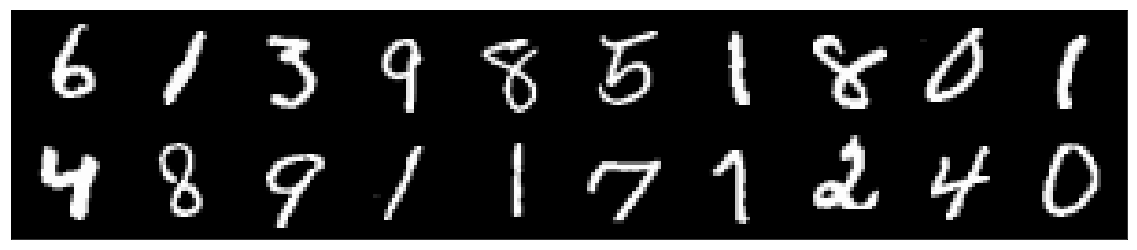

epoch = 83


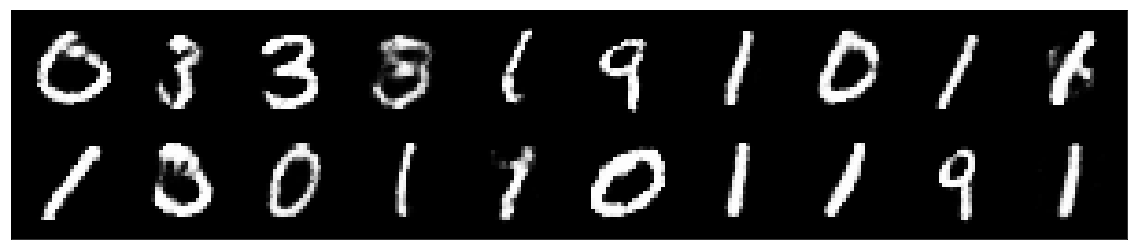

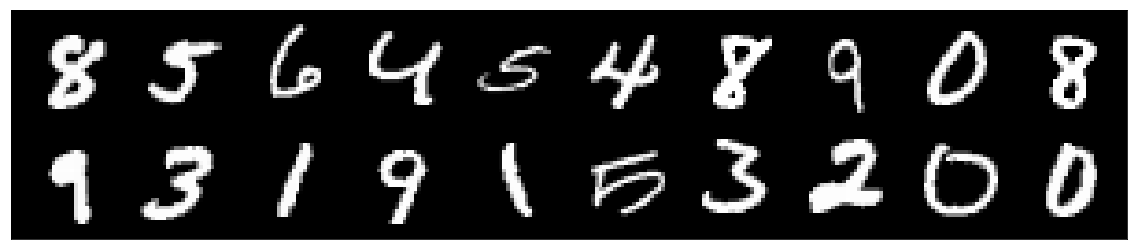

epoch = 84


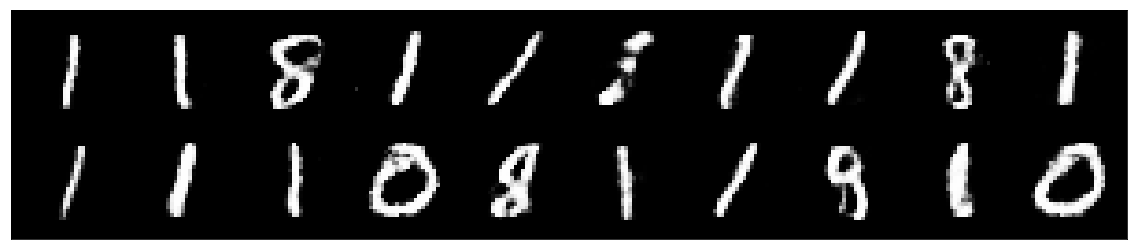

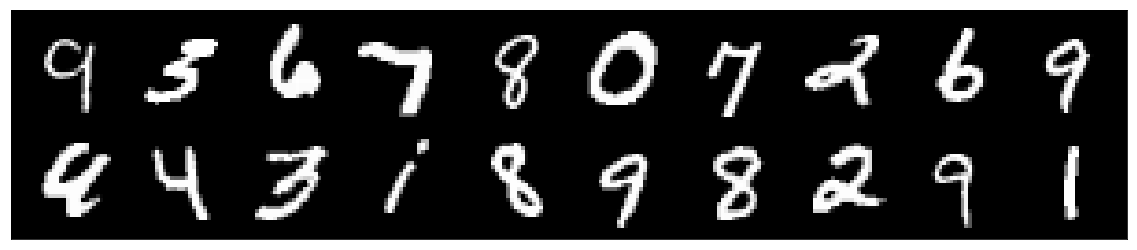

epoch = 85


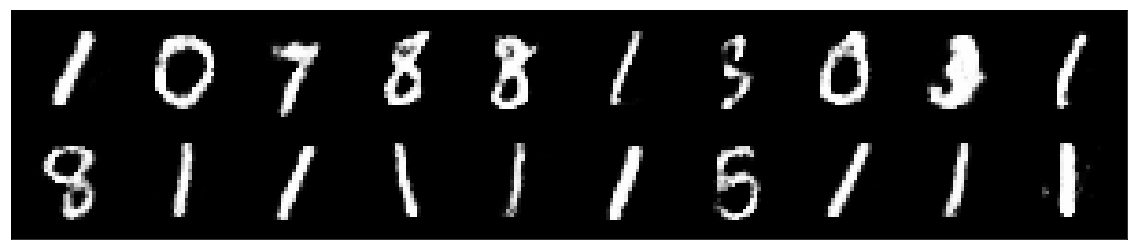

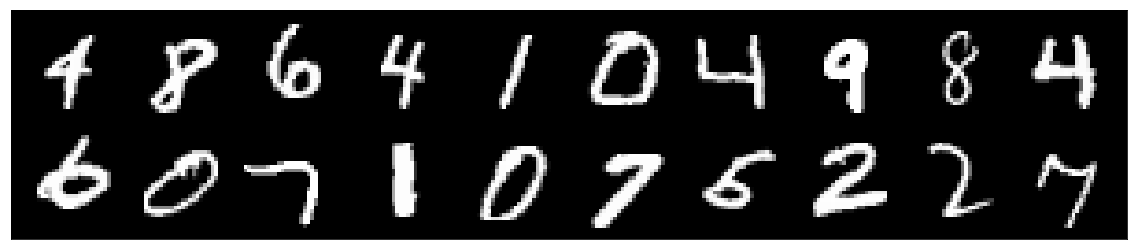

epoch = 86


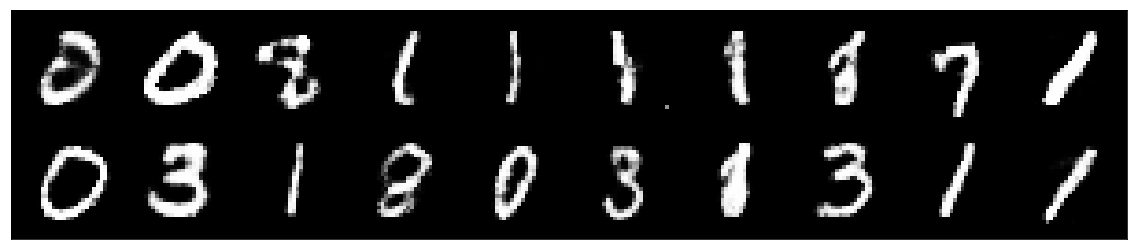

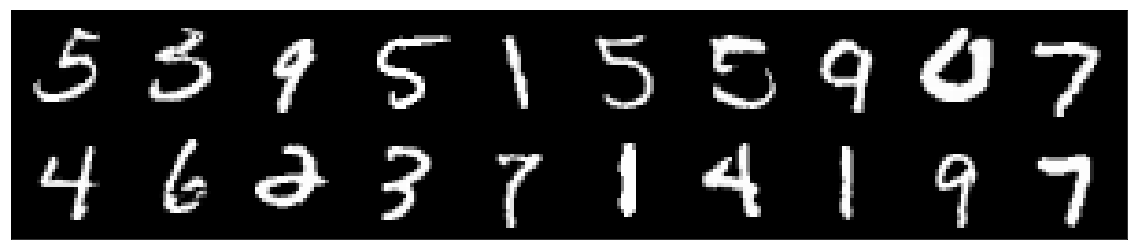

epoch = 87


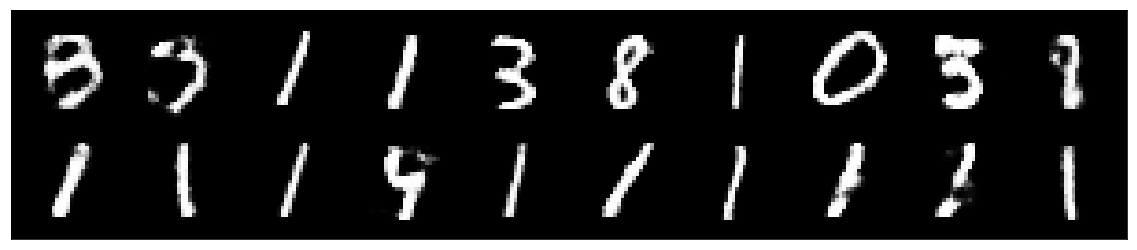

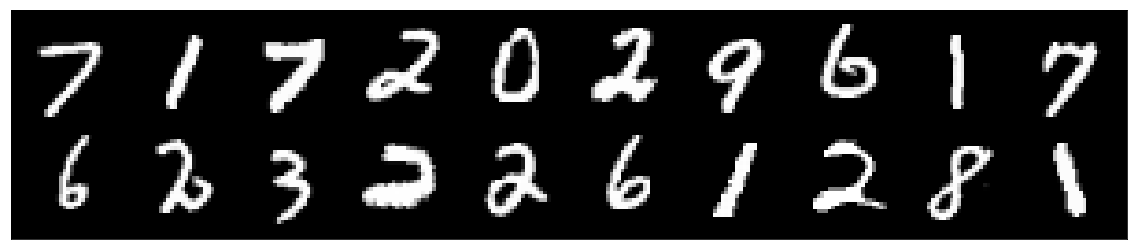

epoch = 88


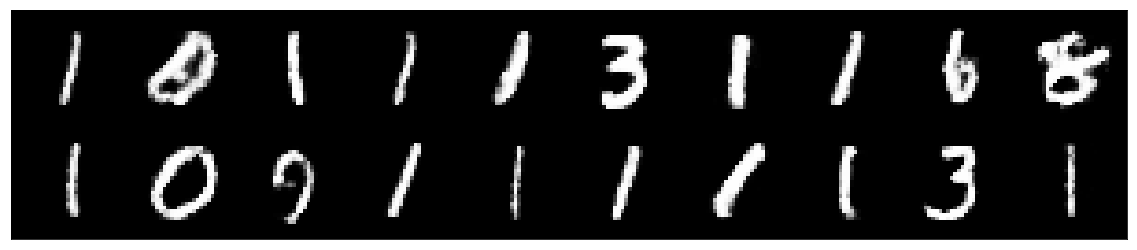

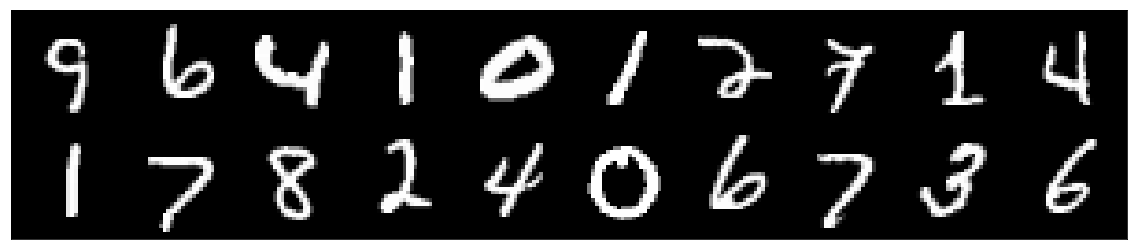

epoch = 89


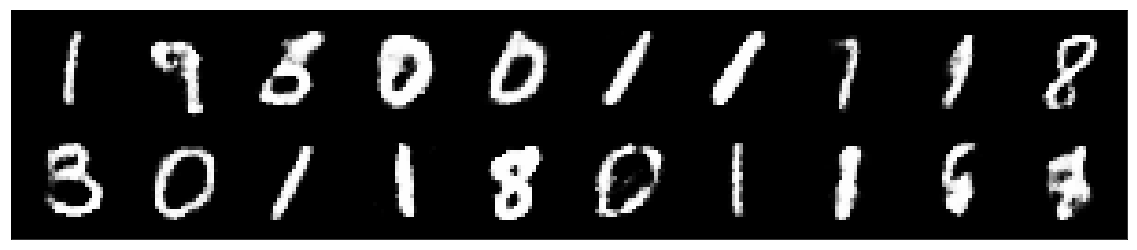

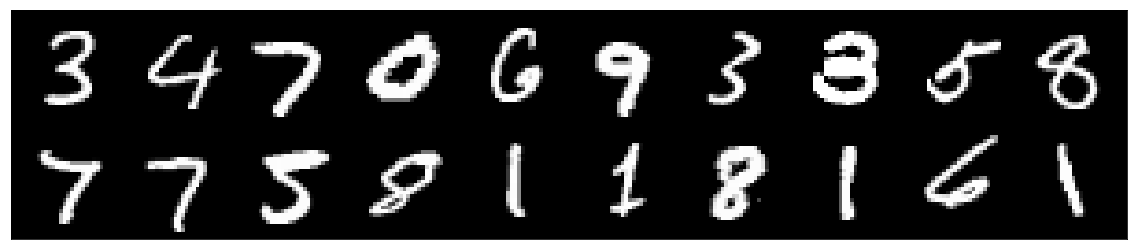

epoch = 90


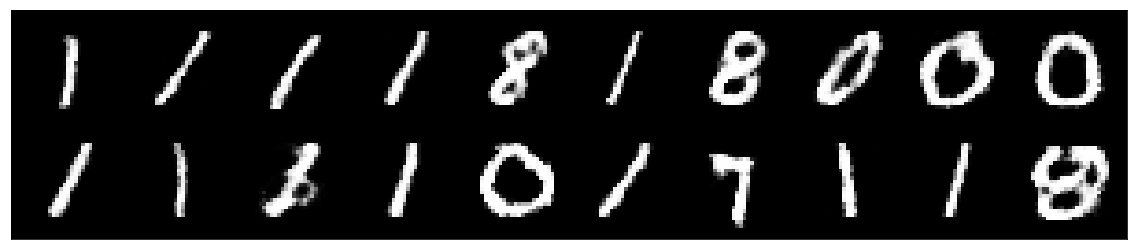

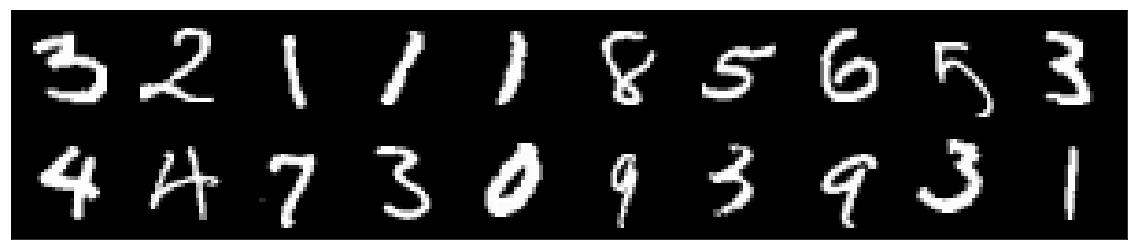

epoch = 91


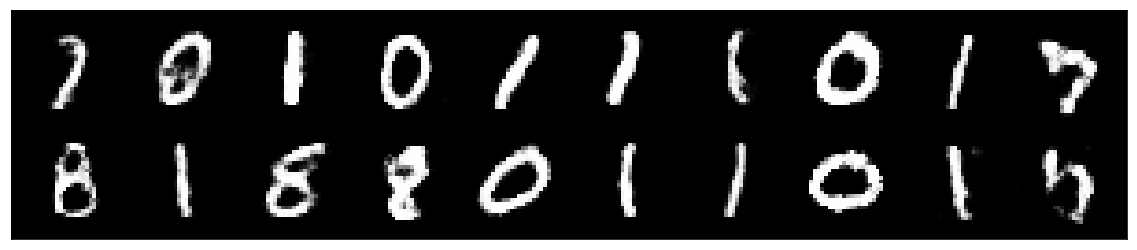

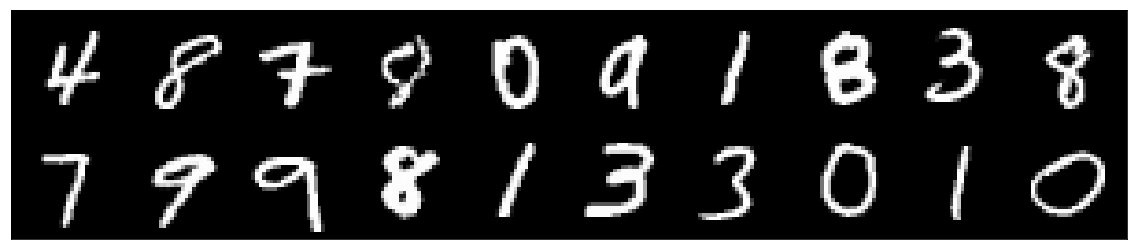

epoch = 92


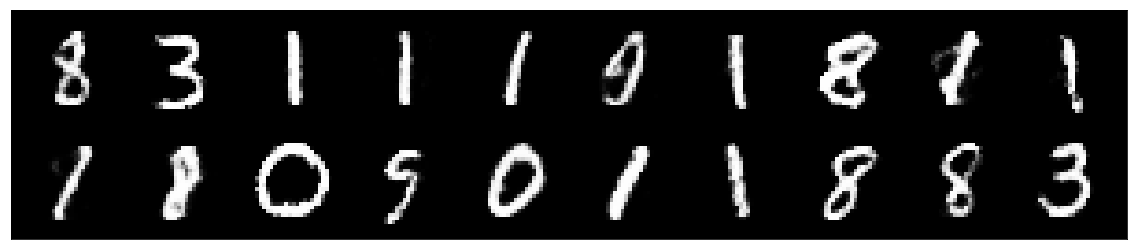

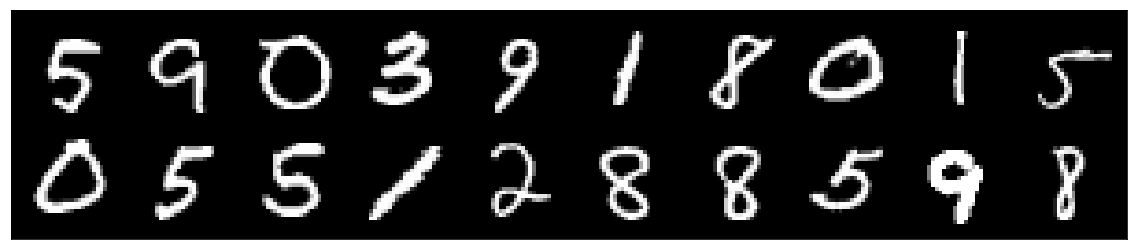

epoch = 93


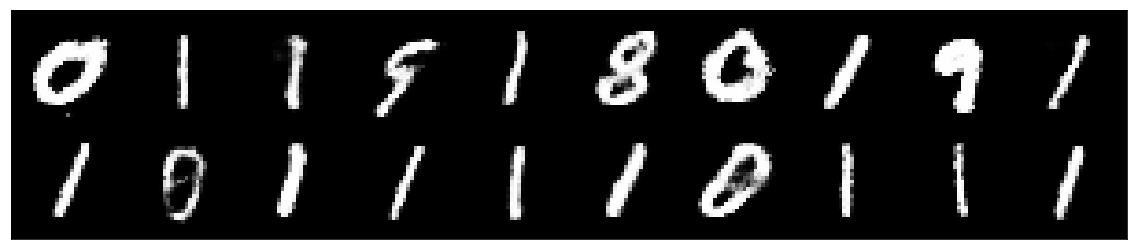

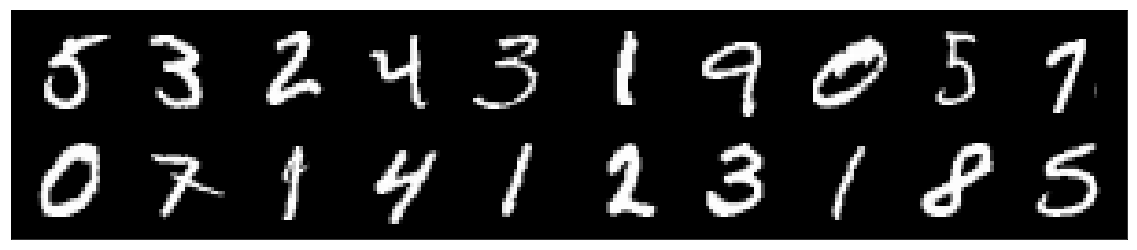

epoch = 94


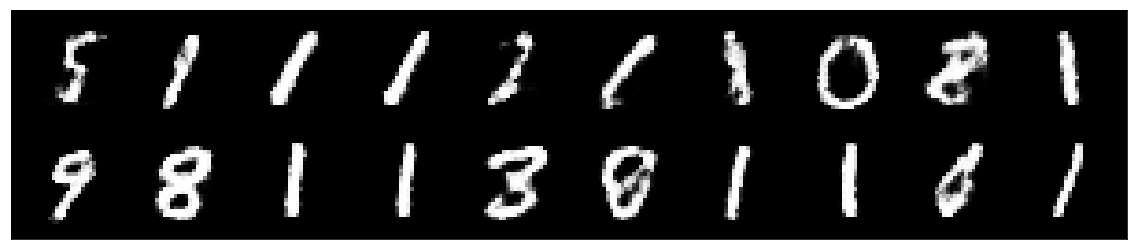

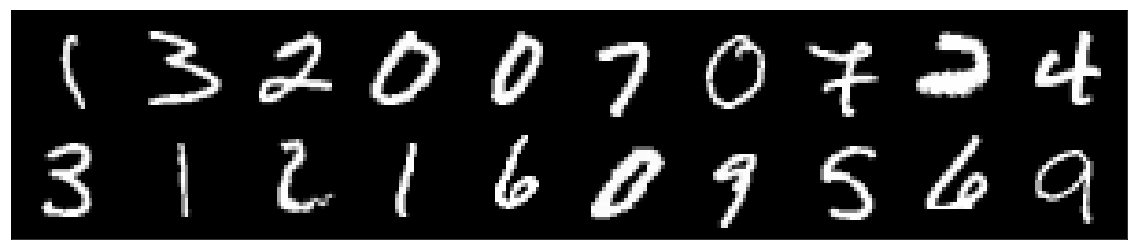

epoch = 95


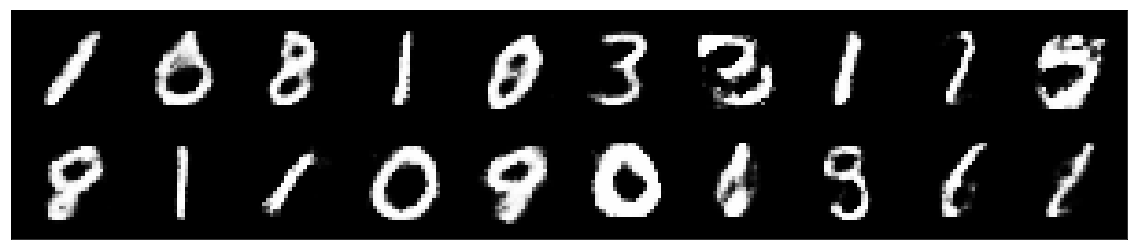

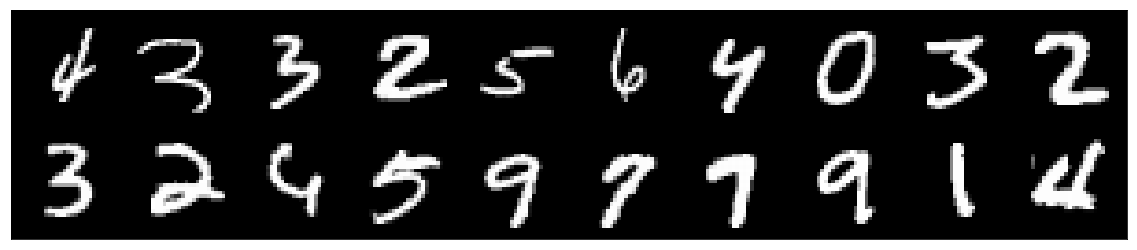

epoch = 96


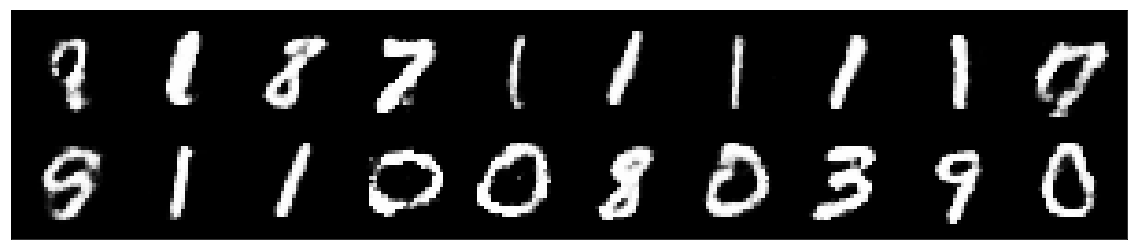

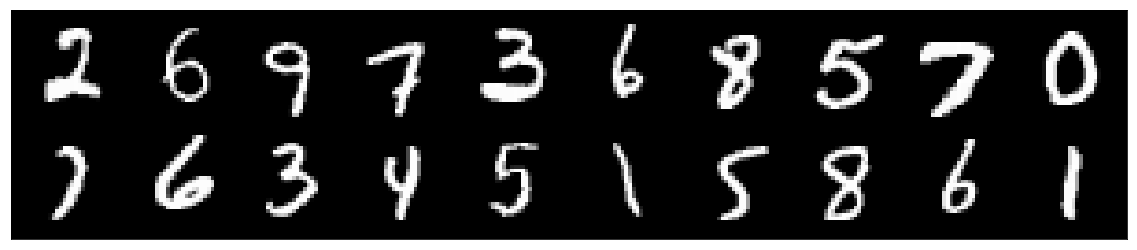

epoch = 97


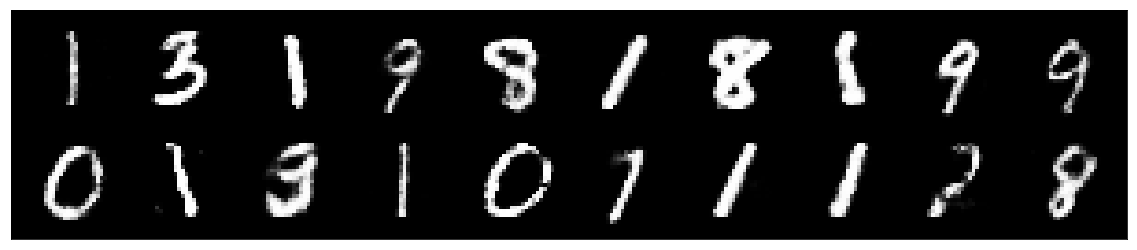

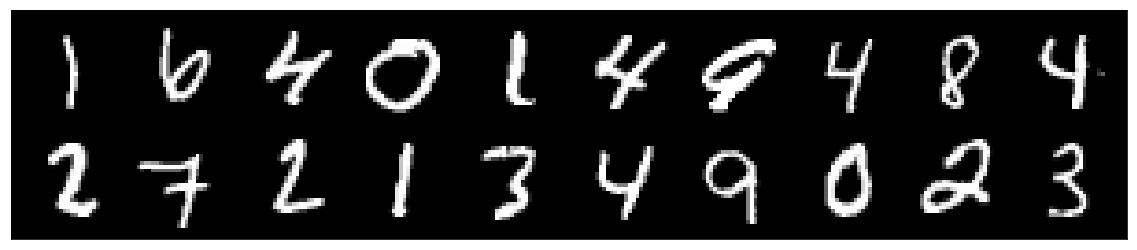

epoch = 98


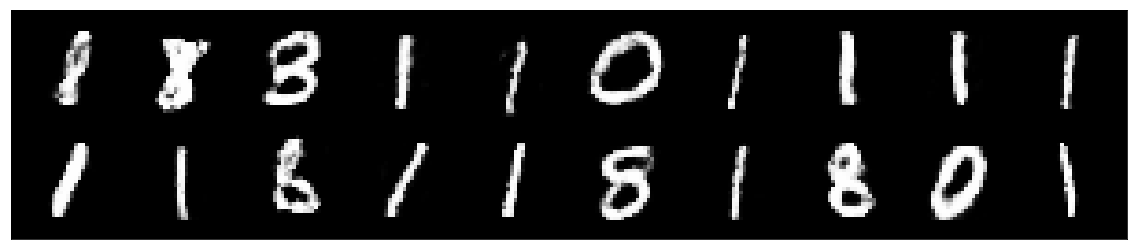

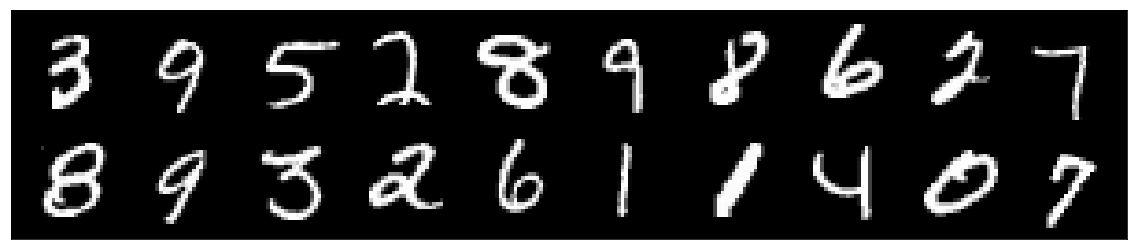

epoch = 99


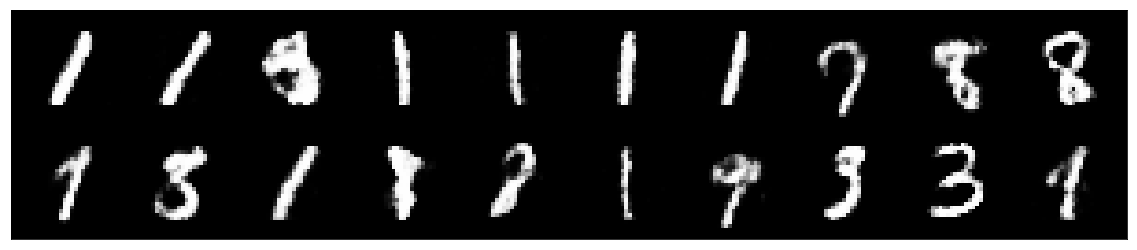

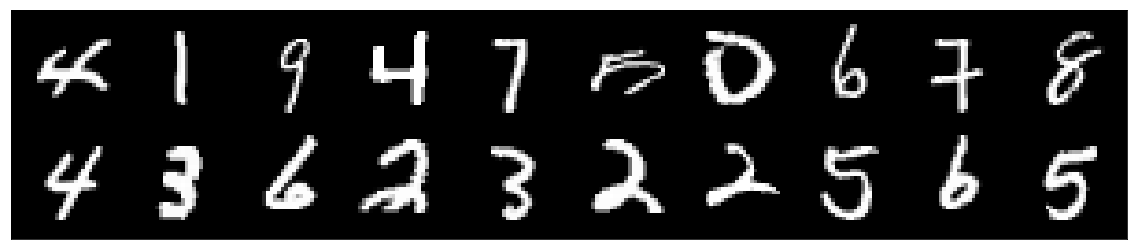

In [79]:
n_epochs = 100
for epoch in range(n_epochs):
    for r, _ in train_loader:
        batch_size = r.shape[0]
        z = torch.randn(batch_size,10)
        real = r.view(batch_size,-1)
        ### Discriminator updates
        opt_disc.zero_grad()
        disc_loss = fun_disc_loss(disc, real, gen, z, criterion, batch_size)
        disc_loss.backward()
        opt_disc.step()
        ### Generator updates
        opt_gen.zero_grad()
        gen_loss = fun_gen_loss(disc, real, gen, z, criterion, batch_size)
        gen_loss.backward()
        opt_gen.step()
    feak = gen(z)
    print(f'epoch = {epoch}')
    fun_plot(feak, shape=(1,28,28))
    fun_plot(real, shape=(1,28,28))